# [IT8701] Introduction to Programming for Data Science: HDB Data Analysis

__Name__: Sng Tian Hao, Keith <br>
__Student ID__: 1273381F <br>
__Class__: C <br>
__Tutor__: Chia Yao An Kendrick

## Table of Contents
- [Libraries](#1)
- [Data analysis](#2)
    - [BTO prices](#2_1)
    - [HDB resale prices](#2_2)
    - [BTO or resale?](#2_3)
    - [HDB grants by year](#2_4)
    - [HDB FAM approvals by year](#2_5)
    - [HDB rental prices](#2_6)
- [Limitations of Study](#3)

<br>__Introduction__<br>
In Singapore’s public housing landscape, there are numerous housing options ranging from Build-To-Order (BTO) flats, resale flats, and rental units, each with its own costs and advantages. As a prospective first-time home owner, there are many factors to take into consideration such as location, convenience, waiting times, finances, and eligibility for grants. While it may seem overwhelming, with the right information, prospective buyers can make better decisions in their quest to find their perfect homes. <br>

By utilising five HDB housing datasets and creating various visualisations with using the `numpy` and `matplotlib` library (alongside other supporting libraries), this project seeks to elucidate trends and insights to guide prospective first-time home owners with their housing purchase.

__Aim__<br>
In particular, we aim to answer the following questions:
1. Which housing option to choose (BTO, resale or rental)?
2. Where to stay?
3. How easy/difficult is it to secure financial support (i.e., grants or HDB financial assistance measures)?

__Datasets used__<br>
1. [Price Range of HDB Flats Offered](https://beta.data.gov.sg/collections/177/datasets/d_2d493bdcc1d9a44828b6e71cb095b88d/view)
2. [Number of approved applications for financial assistance measures](https://beta.data.gov.sg/datasets/d_c2b211174c4e0f546b4d8e92c6aaf365/view)
3. [CPF Housing Grants Awarded by Type](https://beta.data.gov.sg/datasets/d_a223380e5856cf06f7eac223e5902230/view)
4. [Resale flat prices based on registration date from Jan-2017 onwards](https://beta.data.gov.sg/datasets/d_8b84c4ee58e3cfc0ece0d773c8ca6abc/view)
5. [Renting Out of Flats 2024 (CSV)](https://beta.data.gov.sg/datasets/d_c9f57187485a850908655db0e8cfe651/view)

# 1. Import Libraries <a id = '1'></a>

In [4]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from helperFunc import get_coordinates # self-defined function for geocoding
from matplotlib.ticker import FuncFormatter
from numpy.lib.recfunctions import append_fields
import geopandas as gpd
import matplotlib.patches as mpatches

%config InlineBackend.figure_format='retina'

# 2. Data Analysis <a id = '2'></a> 

As first-time buyers, BTOs and resale flats are often the first two public housing options to be considered. First, we analysed BTO price data from 2018-2021 to evaluate the affordaibility of BTOs and identify suitable locations for buyers to select based on their budget.

## 2.1. HDB BTO prices <a id = '2_1'></a>

__Load data__

In [176]:
# Read data and fill NA where applicable
bto = np.genfromtxt('../02_Data/PriceRangeofHDBFlatsOffered.csv', delimiter=',', skip_header=1,
                    dtype=[('financial_year', 'u8'), ('town', 'U50'), ('room_type', 'U50'), ('min_selling_price', 'i8'),
                           ('max_selling_price', 'i8'), ('min_selling_price_less_ahg_shg', 'i8'), ('max_selling_price_less_ahg_shg', 'i8')],
                    missing_values=['na'], filling_values=0)

# View first 5 rows
bto[:5]

array([(2008, 'Punggol', '2-room',  82000, 107000, 0, 0),
       (2008, 'Punggol', '3-room', 135000, 211000, 0, 0),
       (2008, 'Punggol', '4-room', 223000, 327000, 0, 0),
       (2008, 'Punggol', '5-room', 305000, 428000, 0, 0),
       (2008, 'Jurong West', '3-room', 142000, 160000, 0, 0)],
      dtype=[('financial_year', '<u8'), ('town', '<U50'), ('room_type', '<U50'), ('min_selling_price', '<i8'), ('max_selling_price', '<i8'), ('min_selling_price_less_ahg_shg', '<i8'), ('max_selling_price_less_ahg_shg', '<i8')])

In [177]:
print('***** Data Inspection *****\n')

# Check for correct number of years
print('*** Check for duplicate years ***')
print(f"{np.unique(bto['financial_year'])}\n")

# Check for any duplicates in towns
print('*** Check for duplicate towns ***')
print(f"{np.unique(bto['town'])}\n")

# Check for any duplicates in room types
print('*** Check for duplicate room types ***')
print(f"{np.unique(bto['room_type'])}") # trailing whitespace detected: '2-room '

***** Data Inspection *****

*** Check for duplicate years ***
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]

*** Check for duplicate towns ***
['Bukit Batok' 'Bukit Panjang' 'Choa Chu Kang' 'Hougang' 'Jurong East'
 'Jurong West' 'Punggol' 'Sembawang' 'Sengkang' 'Tengah' 'Woodlands'
 'Yishun']

*** Check for duplicate room types ***
['2-room' '2-room ' '3-room' '4-room' '5-room']


<div class='alert alert-block alert-warning'>
<b>ALERT</b>: Whitespace detected for one of the values. To clean dataset before visualisation.
</div>

__Data cleaning__

In [178]:
# Data cleaning, trailing whitespace detected in room type
bto['room_type'][bto['room_type'] == '2-room '] = '2-room'

# Create new feature for analysis
average_selling_price = (bto['max_selling_price'] + bto['min_selling_price']) / 2

# Append field to bto array
bto = append_fields(bto, 'average_selling_price', average_selling_price, usemask=False)

In [179]:
# Check range of values for average_selling_price
print('*** Check range of values for average selling price ***')
print(bto['average_selling_price']) # 0s spotted, does not make sense to have a project for $0
print('\n')

# Inspect dataset to examine issue
print(bto[bto['average_selling_price'] == 0]) # most likely empty records (i.e., no projects for te particular town and room type, hence $0)

# Remove rows with average_selling_price = 0
bto = bto[bto['average_selling_price'] > 0]

*** Check range of values for average selling price ***
[ 94500. 173000. 275000. 366500. 151000. 232000. 274000.  94000. 154000.
 240500. 140000. 220500. 271500.  84000. 141000. 232500. 328500. 101500.
 169500. 278000. 370500.  94500. 155500. 244500.  93500. 150000. 243500.
  83000. 141000. 230000. 158000. 258000.  86000. 143500. 237000. 316500.
 193500. 309500. 394000. 183500. 282000. 344500. 101000. 167000. 269000.
 348000.  91500. 152000. 252000. 299000.  94000. 177000. 280000. 361500.
  98000. 196000. 323500. 409500. 159000. 256500. 329500. 163000. 257500.
 330000. 104000. 174500. 282500.  97500. 177000. 297500. 369500. 174500.
 265000. 329000. 117000. 205000. 319500. 405500. 110000. 160000. 266000.
 334500. 280000. 344500. 207500. 327000. 401500. 183500. 292000. 359500.
 111000. 204000. 328000. 430000. 156000. 264000. 340000.  95500. 158000.
 260500. 322500.  89500. 157500. 264500. 347000. 100000. 169500. 290000.
 391500.  96500. 192000. 286000. 354500. 111000. 185500. 301500. 403

__Decsriptive stats__

In [162]:
# Define variables for header print
header = ' BTO flat prices from 2018 to 2021 '
bto_len = len(bto)

# Print header
print(f'{header:*^{len(header)+10}}')

# Print number of rows in dataset
print(f'There are a total of {bto_len:,} rows in this dataset\n')

# Get unique room types
room_types = np.unique(bto['room_type'])

# Descriptive stats for each room type
print(f'Within this dataset, there are {len(room_types)} unique room types')
print('For each room type, the following stats and information are extracted to elucidate trends in BTO prices\n')

# Create empty lists for appending descriptive stats for each room type
mean_price_by_room_type = []
price_sd_by_room_type = []
max_price_by_room_type = []
estate_of_max_price_by_room_type = []
year_of_max_price_by_room_type = []

# Iterate through list of room types to filter dataset relevant to each room type
for i in room_types:
    # Filter and get stats for each flat type
    mean_price = round(np.mean(bto[bto['room_type'] == i]['average_selling_price']), 2)
    price_std = round(np.std(bto[bto['room_type'] == i]['average_selling_price']), 2)
    max_price = np.max(bto[bto['room_type'] == i]['average_selling_price'])
    estate_max = bto[np.argmax(bto[bto['room_type'] == i]['average_selling_price'])]['town']
    month_max = bto[np.argmax(bto[bto['room_type'] == i]['average_selling_price'])]['financial_year']

    # Append summary statistic for each room type into respective list
    mean_price_by_room_type.append(mean_price)
    price_sd_by_room_type.append(price_std)
    max_price_by_room_type.append(max_price)
    estate_of_max_price_by_room_type.append(estate_max)
    year_of_max_price_by_room_type.append(month_max)

# Print out stats for each room type
for i in range(len(room_types)):
    print(f'{room_types[i]:*^{len(room_types[i])+6}}')
    print(f'Mean: ${mean_price_by_room_type[i]:,.2f}')
    print(f'Standard deviation: ${price_sd_by_room_type[i]:,.2f}')
    print(f'Max: ${max_price_by_room_type[i]:,.2f}')
    print(f'Estate of most expensive BTO: {estate_of_max_price_by_room_type[i]}')
    print(f'Year of most expensive BTO: {year_of_max_price_by_room_type[i]}\n')

***** BTO flat prices from 2018 to 2021 *****
There are a total of 265 rows in this dataset

Within this dataset, there are 4 unique room types
For each room type, the following stats and information are extracted to elucidate trends in BTO prices

***2-room***
Mean: $110,169.49
Standard deviation: $17,716.84
Max: $171,000.00
Estate of most expensive BTO: Punggol
Year of most expensive BTO: 2011

***3-room***
Mean: $183,986.11
Standard deviation: $26,462.50
Max: $269,500.00
Estate of most expensive BTO: Sembawang
Year of most expensive BTO: 2011

***4-room***
Mean: $289,506.76
Standard deviation: $34,303.15
Max: $407,500.00
Estate of most expensive BTO: Sengkang
Year of most expensive BTO: 2011

***5-room***
Mean: $377,808.33
Standard deviation: $45,800.03
Max: $487,000.00
Estate of most expensive BTO: Woodlands
Year of most expensive BTO: 2010



__`Bar plot` of BTO prices by room type and estate__

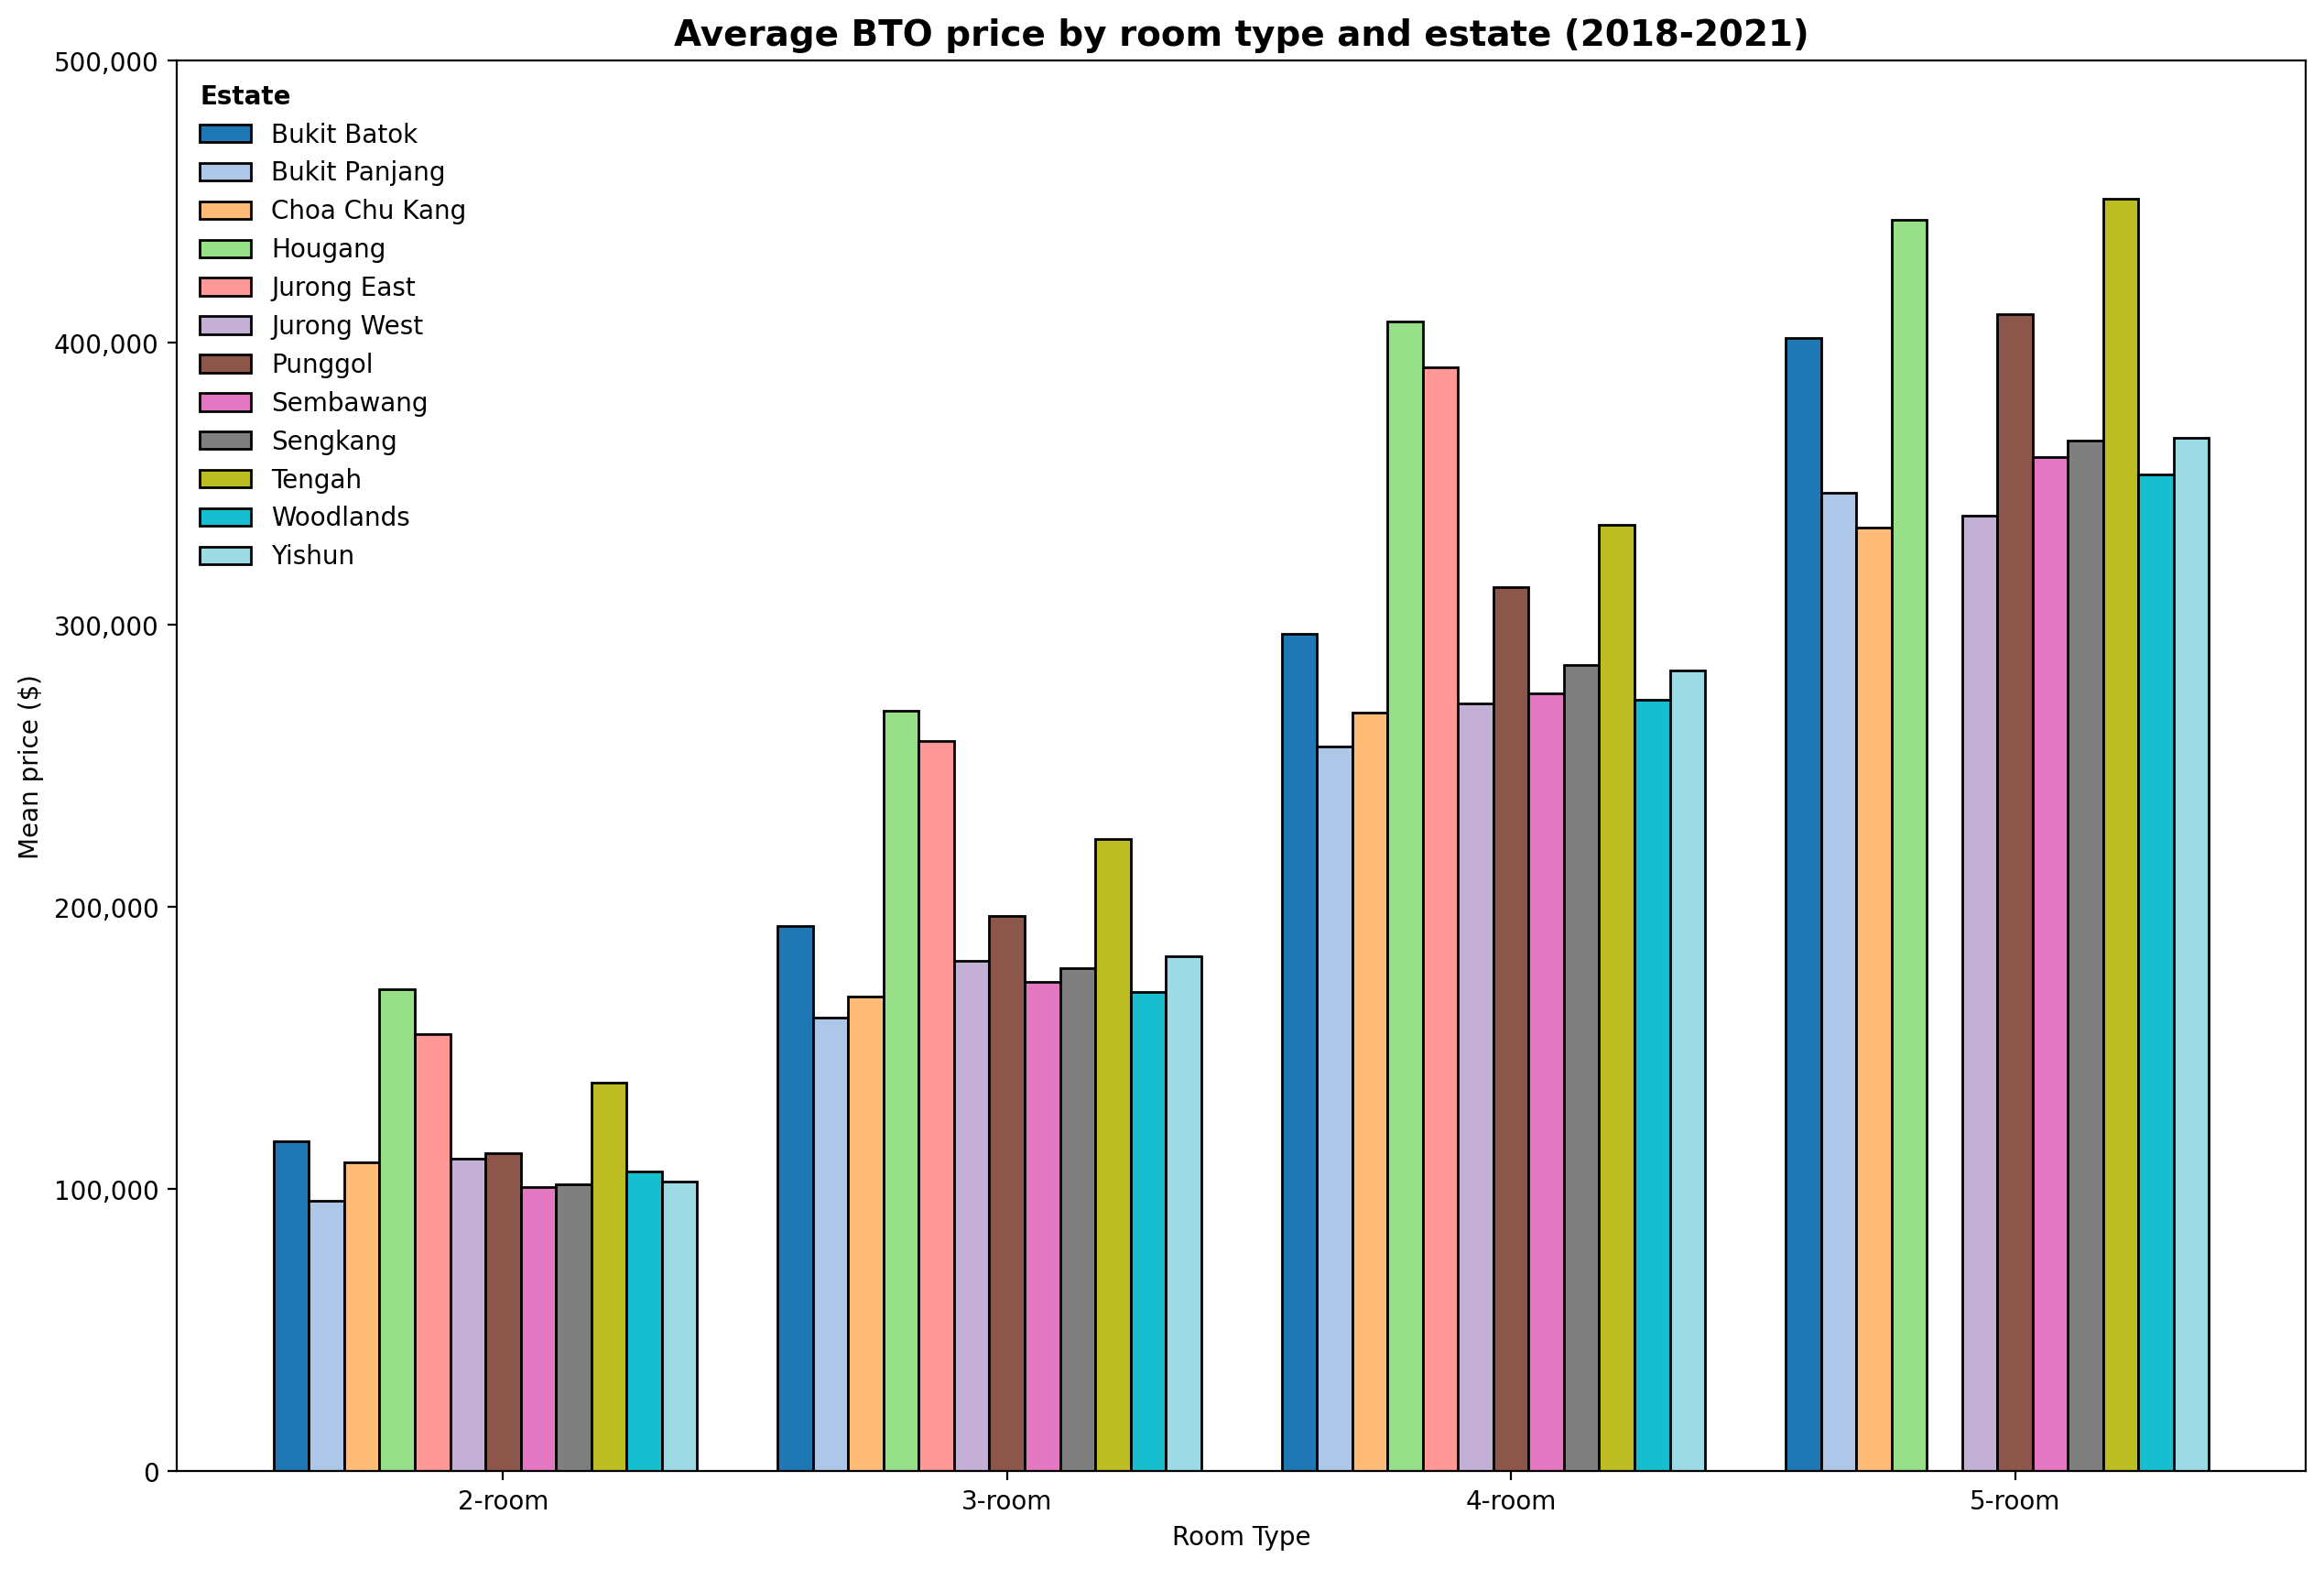

In [163]:
# Get unique estates
estates = np.unique(bto['town'])

# Store mean price of each room type per estate as a list of arrays
mean_price_by_estate_room_type = []

# Iterate through each room type: one room type = one array
for estate in estates:
    mean_price = []
    # Iterate through each estate and calculate mean price for that estate
    for room in room_types:
        mean_price.append(round(np.mean(bto[(bto['town'] == estate) & (bto['room_type'] == room)]['average_selling_price']), 2))
    mean_price_by_estate_room_type.append(np.array(mean_price))


# Initiate figure
plt.figure(figsize=(15,10))
plt.style.use('default')

# Bar chart labels
plt.title('Average BTO price by room type and estate (2018-2021)', fontweight='bold', fontsize=14)
plt.ylabel('Mean price ($)')
plt.xlabel('Room Type')

# Bar chart ticks and tick labels
x = np.arange(len(room_types))
width = 0.07
offset = np.concatenate([-np.arange(len(estates)//2+1)[::-1], np.arange(1,len(estates)//2)]) * width # Create array of offset values evenly spaced and centred around 0 
colours = mpl.colormaps['tab20'](np.linspace(0, 1, 12)) # Select 12 colours, one for each estate

# Plot bars for each estate for each room type
for i in range(len(estates)):
    plt.bar(x+offset[i], mean_price_by_estate_room_type[i], width, color=colours[i], align='center', edgecolor='black')

# Ticks, labels and legend
plt.xticks(x, room_types)
plt.yticks(np.arange(0,600000,100000), ['{:,}'.format(i) for i in np.arange(0,600000,100000)])
plt.legend(estates, frameon=False, loc='upper left', title='Estate', title_fontproperties={'weight': 'bold'}, alignment='left')

# Show plot
plt.show()

This bar graph provides buyers with an overiew of BTO prices across various room types and housing estates, enabling them to understand the price range across Singapore. With this information, buyers can choose a suitable BTO project in their preferred estate and room type according to their budget. <br>

In general, prices tend to increase with the size of BTO units across the different housing estates. <br>

However, there are variations in prices within each room category across the estates. For example, when comparing 4-room flats, Hougang and Jurong East stand out for having notably higher prices when compared to that of Yishun and Choa Chu Kang. On the other hand, among 5-room flats, Tengah stands as the most expensive estate. <br>

Nevertheless, the rate at which prices increase seems to vary, and it's not as straightforwardly linear as expected. For example, the mean price for 5-room flats in Choa Chu Kang, Jurong West, and Sembawang is lower than that of their 4-room flats. This difference might be attributed to factors such as limited historical/recent data, leading to fewer data points for certain estates (e.g., only three 5-room BTO sales data between 2011-2013 and no offerings in recent years, resulting in significant under-pricing). <br>

In the context of a prospective home owner looking to purchase a 4-room flat under a tight budget (e.g., <$300,000), the person might find BTO projects in estates other than Hougang, Jurong East, Tengah, and Punggol more palatable.

## 2.2. HDB resale prices <a id = '2_2'></a>

In addition to BTOs, buyers may consider resale flats due to the extended wait times associated with BTO applications. An analysis of HDB resale price data from 2017 to 2024 was conducted to assess the availability of viable resale options for buyers to consider.

__Load data__

In [164]:
# Read data and fill NA where applicable
resale = np.genfromtxt('../02_Data/ResaleflatpricesbasedonregistrationdatefromJan2017onwards.csv', delimiter=',', skip_header=1, 
                       dtype=[('month', 'U50'), ('town', 'U50'), ('flat_type', 'U50'), ('block', 'U10'), ('street_name', 'U50'), ('storey_range', 'U50'), 
                              ('floor_area_sqm', 'f8'), ('flat_model', 'U50'), ('lease_commence_date', 'u8'), ('remaining_lease', 'U50'), ('resale_price', 'f8')], 
                        missing_values=['na'], filling_values=0)

# View first 5 rows
resale[:5]

array([('2017-01', 'ANG MO KIO', '2 ROOM', '406', 'ANG MO KIO AVE 10', '10 TO 12', 44., 'Improved', 1979, '61 years 04 months', 232000.),
       ('2017-01', 'ANG MO KIO', '3 ROOM', '108', 'ANG MO KIO AVE 4', '01 TO 03', 67., 'New Generation', 1978, '60 years 07 months', 250000.),
       ('2017-01', 'ANG MO KIO', '3 ROOM', '602', 'ANG MO KIO AVE 5', '01 TO 03', 67., 'New Generation', 1980, '62 years 05 months', 262000.),
       ('2017-01', 'ANG MO KIO', '3 ROOM', '465', 'ANG MO KIO AVE 10', '04 TO 06', 68., 'New Generation', 1980, '62 years 01 month', 265000.),
       ('2017-01', 'ANG MO KIO', '3 ROOM', '601', 'ANG MO KIO AVE 5', '01 TO 03', 67., 'New Generation', 1980, '62 years 05 months', 265000.)],
      dtype=[('month', '<U50'), ('town', '<U50'), ('flat_type', '<U50'), ('block', '<U10'), ('street_name', '<U50'), ('storey_range', '<U50'), ('floor_area_sqm', '<f8'), ('flat_model', '<U50'), ('lease_commence_date', '<u8'), ('remaining_lease', '<U50'), ('resale_price', '<f8')])

In [165]:
print('***** Data Inspection *****\n')

# Check for correct number of years
print('*** Check for duplicate months ***')
print(f"{np.unique(resale['month'])}\n")

# Check for duplicates of towns
print('*** Check for duplicate towns ***')
print(f"{np.unique(resale['town'])}\n")

# Check for duplicates of room types
print('*** Check for duplicate flat types ***')
print(f"{np.unique(resale['flat_type'])}\n")

# Check for duplicates of flat models
print('*** Check for duplicate flat models ***')
print(f"{np.unique(resale['flat_model'])}")

***** Data Inspection *****

*** Check for duplicate months ***
['2017-01' '2017-02' '2017-03' '2017-04' '2017-05' '2017-06' '2017-07'
 '2017-08' '2017-09' '2017-10' '2017-11' '2017-12' '2018-01' '2018-02'
 '2018-03' '2018-04' '2018-05' '2018-06' '2018-07' '2018-08' '2018-09'
 '2018-10' '2018-11' '2018-12' '2019-01' '2019-02' '2019-03' '2019-04'
 '2019-05' '2019-06' '2019-07' '2019-08' '2019-09' '2019-10' '2019-11'
 '2019-12' '2020-01' '2020-02' '2020-03' '2020-04' '2020-05' '2020-06'
 '2020-07' '2020-08' '2020-09' '2020-10' '2020-11' '2020-12' '2021-01'
 '2021-02' '2021-03' '2021-04' '2021-05' '2021-06' '2021-07' '2021-08'
 '2021-09' '2021-10' '2021-11' '2021-12' '2022-01' '2022-02' '2022-03'
 '2022-04' '2022-05' '2022-06' '2022-07' '2022-08' '2022-09' '2022-10'
 '2022-11' '2022-12' '2023-01' '2023-02' '2023-03' '2023-04' '2023-05'
 '2023-06' '2023-07' '2023-08' '2023-09' '2023-10' '2023-11' '2023-12'
 '2024-01' '2024-02' '2024-03' '2024-04' '2024-05']

*** Check for duplicate towns *

__Descriptive stats__

In [166]:
# Define variables for header print
header = ' Resale flat prices from Jan 2017 to May 2024 '
resale_len = len(resale)

# Print header
print(f'{header:*^{len(header)+10}}')

# Print number of rows in dataset
print(f'There are a total of {resale_len:,} rows in this dataset\n')

# Get unique flat types
flat_types = np.unique(resale['flat_type'])

# Descriptive stats for each flat type
print(f'Within this dataset, there are {len(flat_types)} unique flat types')
print('For each flat type, the following stats and information are extracted to elucidate trends in HDB prices across the resale market\n')

# Create empty lists for appending descriptive stats for each flat type
mean_price_by_flat_type = []
price_sd_by_flat_type = []
max_price_by_flat_type = []
min_price_by_flat_type = []
estate_of_max_price_by_flat_type = []
month_of_max_price_by_flat_type = []
lease_of_max_price_by_flat_type = []
estate_of_min_price_by_flat_type = []
month_of_min_price_by_flat_type = []
lease_of_min_price_by_flat_type = []

# Iterate through list of flat types to filter dataset relevant to each flat type
for i in flat_types:
    # Filter and get stats for each flat type
    mean_price = round(np.mean(resale[resale['flat_type'] == i]['resale_price']), 2)
    price_std = round(np.std(resale[resale['flat_type'] == i]['resale_price']), 2)
    max_price = np.max(resale[resale['flat_type'] == i]['resale_price'])
    min_price = np.min(resale[resale['flat_type'] == i]['resale_price'])
    estate_max = resale[np.argmax(resale[resale['flat_type'] == i]['resale_price'])]['town']
    month_max = resale[np.argmax(resale[resale['flat_type'] == i]['resale_price'])]['month']
    lease_max = resale[np.argmax(resale[resale['flat_type'] == i]['resale_price'])]['remaining_lease']
    estate_min = resale[np.argmin(resale[resale['flat_type'] == i]['resale_price'])]['town']
    month_min = resale[np.argmin(resale[resale['flat_type'] == i]['resale_price'])]['month']
    lease_min = resale[np.argmin(resale[resale['flat_type'] == i]['resale_price'])]['remaining_lease']

    # Append summary statistic for each flat type into respective list
    mean_price_by_flat_type.append(mean_price)
    price_sd_by_flat_type.append(price_std)
    max_price_by_flat_type.append(max_price)
    min_price_by_flat_type.append(min_price)
    estate_of_max_price_by_flat_type.append(estate_max)
    month_of_max_price_by_flat_type.append(month_max)
    lease_of_max_price_by_flat_type.append(lease_max)
    estate_of_min_price_by_flat_type.append(estate_min)
    month_of_min_price_by_flat_type.append(month_min)
    lease_of_min_price_by_flat_type.append(lease_min)

# Print out stats for each flat type
for i in range(len(flat_types)):
    print(f'{flat_types[i]:*^{len(flat_types[i])+6}}')
    print(f'Mean: ${mean_price_by_flat_type[i]:,.2f}')
    print(f'Standard deviation: ${price_sd_by_flat_type[i]:,.2f}')
    print(f'Max: ${max_price_by_flat_type[i]:,.2f}')
    print(f'Estate of max resale price transaction: {estate_of_max_price_by_flat_type[i]}')
    print(f'Month of max resale price transaction: {month_of_max_price_by_flat_type[i]}')
    print(f'Lease remaining for unit with max resale price: {lease_of_max_price_by_flat_type[i]}')
    print(f'Min: ${min_price_by_flat_type[i]:,.2f}')
    print(f'Estate of min resale price transaction: {estate_of_min_price_by_flat_type[i]}')
    print(f'Month of min resale price transaction: {month_of_min_price_by_flat_type[i]}')
    print(f'Lease remaining for unit with min resale price: {lease_of_min_price_by_flat_type[i]}\n')

***** Resale flat prices from Jan 2017 to May 2024 *****
There are a total of 179,586 rows in this dataset

Within this dataset, there are 7 unique flat types
For each flat type, the following stats and information are extracted to elucidate trends in HDB prices across the resale market

***1 ROOM***
Mean: $201,222.88
Standard deviation: $27,304.20
Max: $258,000.00
Estate of max resale price transaction: BEDOK
Month of max resale price transaction: 2017-01
Lease remaining for unit with max resale price: 63 years 06 months
Min: $157,000.00
Estate of min resale price transaction: ANG MO KIO
Month of min resale price transaction: 2017-01
Lease remaining for unit with min resale price: 62 years

***2 ROOM***
Mean: $275,388.53
Standard deviation: $55,218.16
Max: $585,000.00
Estate of max resale price transaction: BUKIT BATOK
Month of max resale price transaction: 2017-03
Lease remaining for unit with max resale price: 79 years 09 months
Min: $150,000.00
Estate of min resale price transactio

__`Boxplot` of resale price by flat type__

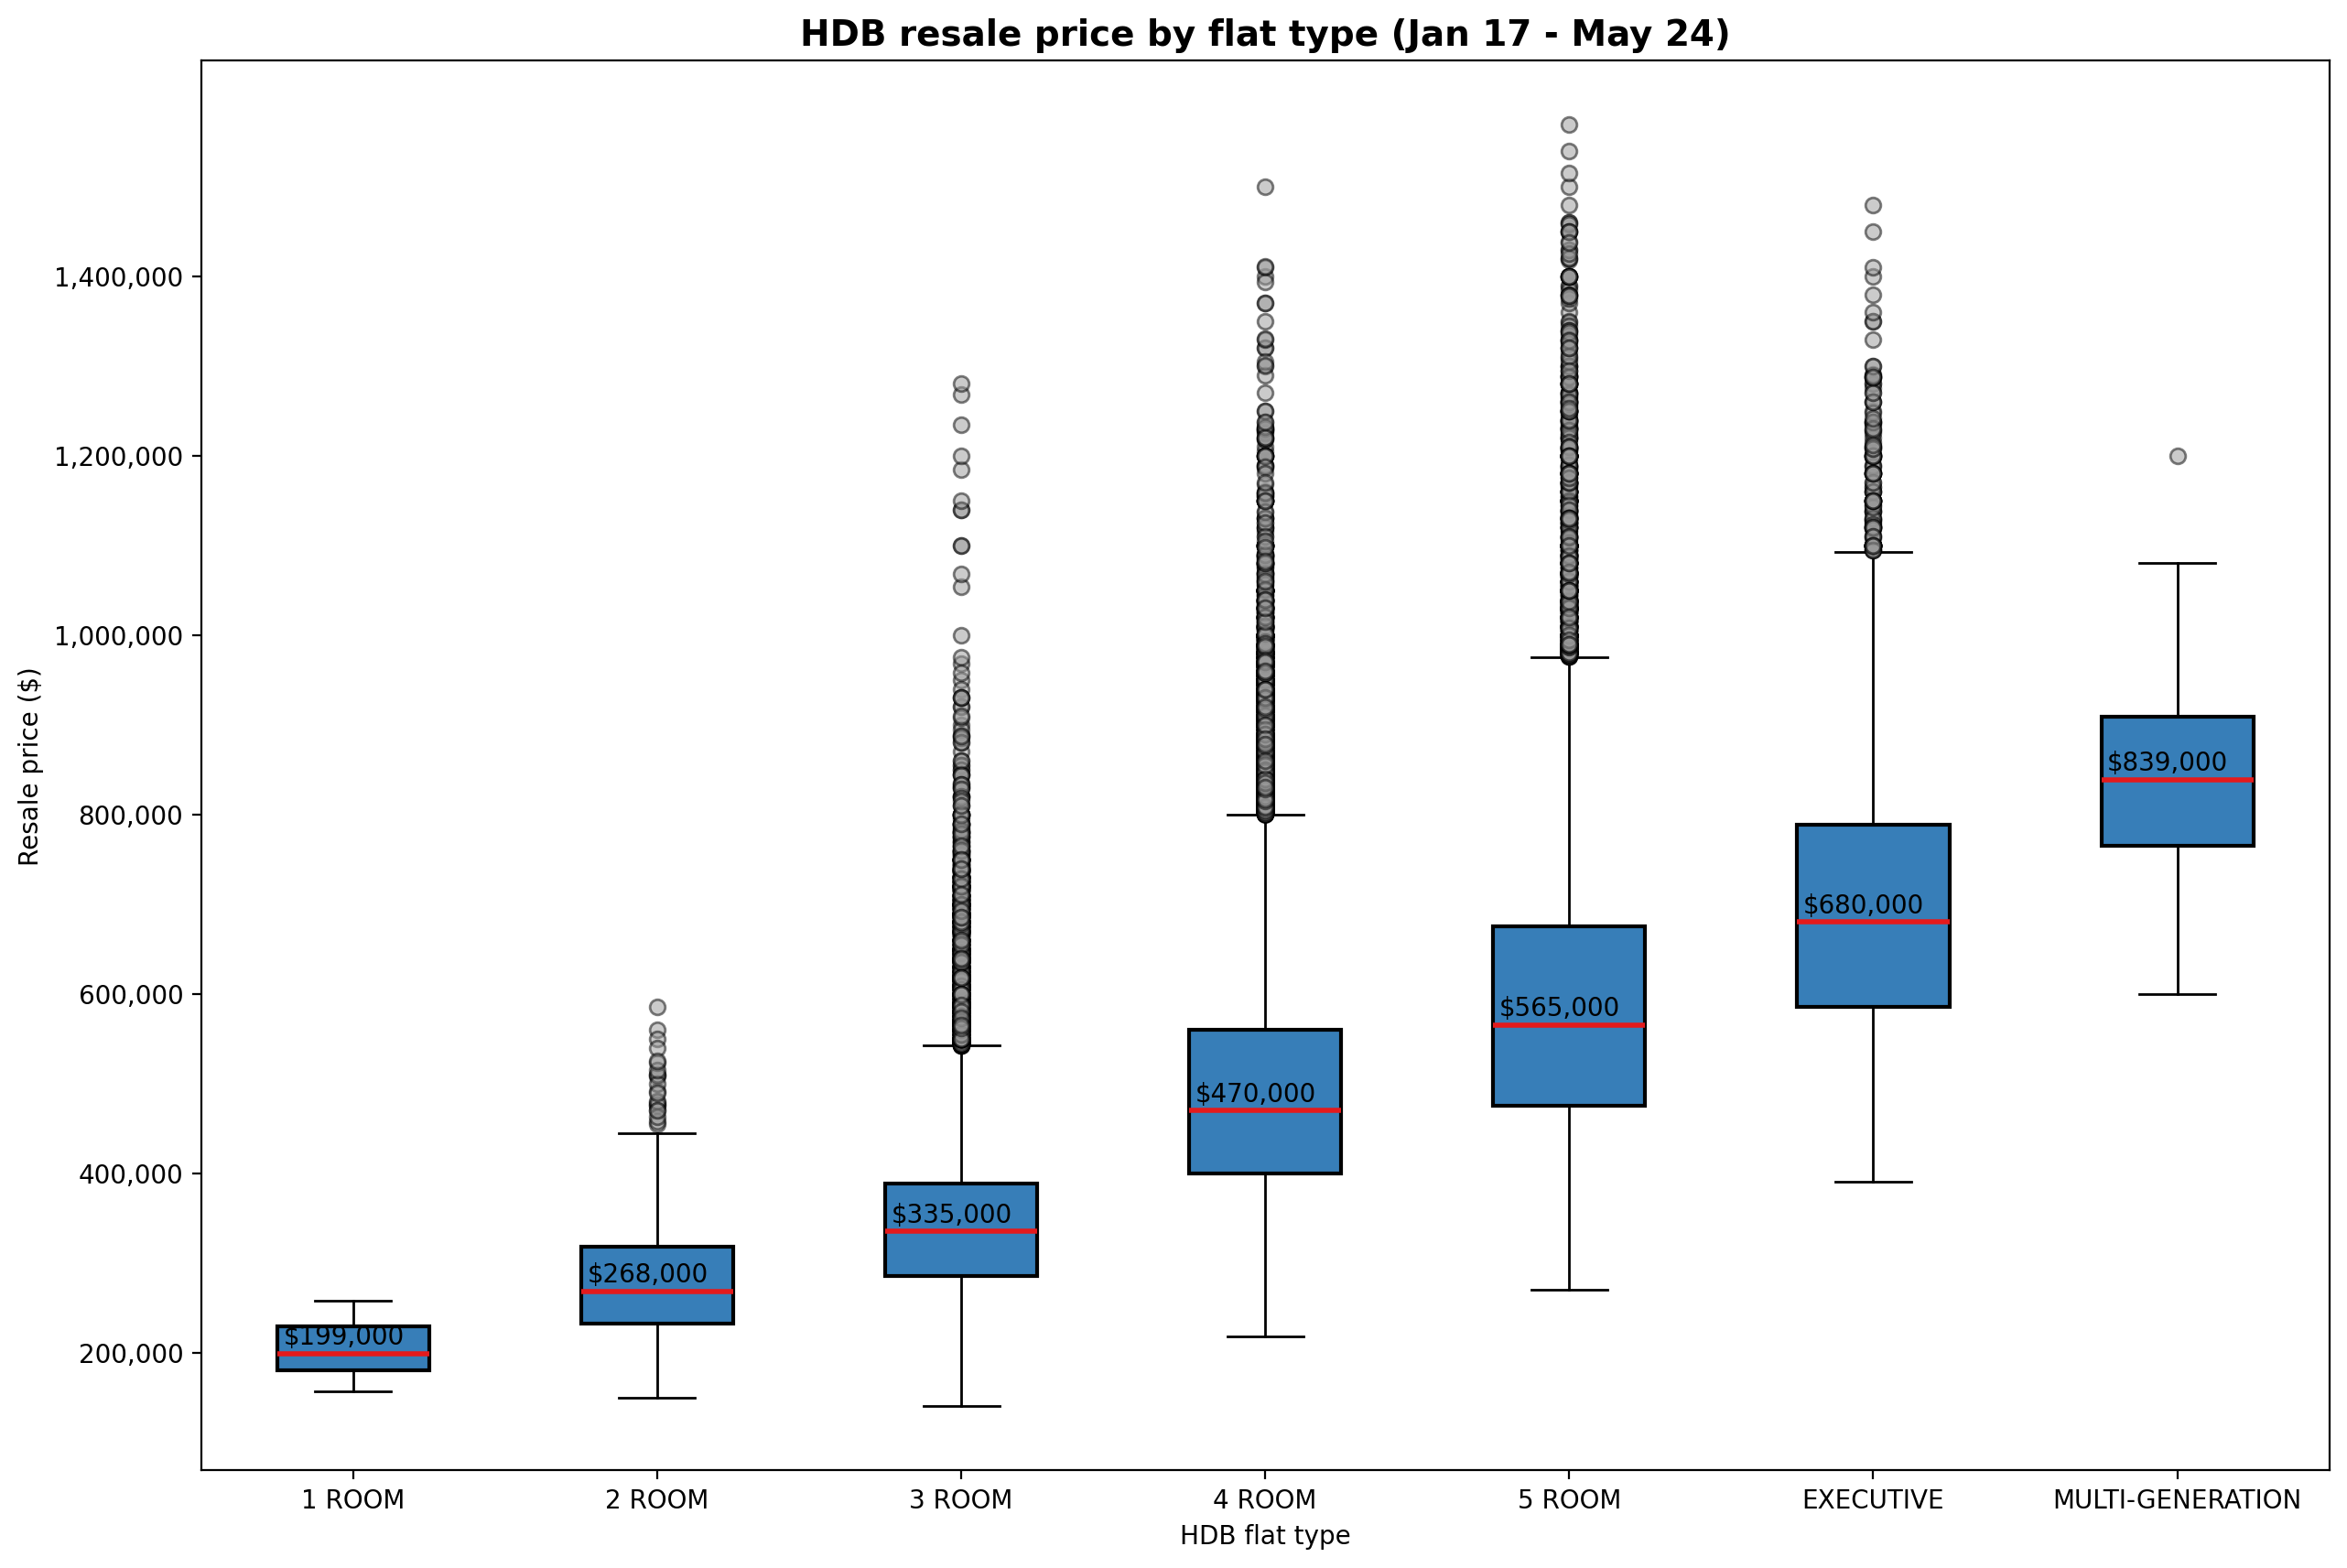

In [167]:
# Store resale price values for each flat type as a list of arrays
resale_price_combined = []
for flat_type in flat_types:
    resale_price_combined.append(resale[resale['flat_type'] == flat_type]['resale_price'])

# Initiate figure
plt.figure(figsize=(15,10))
plt.style.use('default')

# Boxplot labels
plt.title('HDB resale price by flat type (Jan 17 - May 24)', fontweight='bold', fontsize=14)
plt.ylabel('Resale price ($)')
plt.xlabel('HDB flat type')

# Boxplot ticks and tick labels
plt.yticks(np.arange(0,1600000, 200000), ['{:,}'.format(i) for i in np.arange(0,1600000, 200000)])

# Create boxplot object
bp = plt.boxplot(resale_price_combined, labels=flat_types, patch_artist=True)

# Customise boxplot
for box in bp['boxes']:
    box.set(color='black', linewidth=1.5)
    box.set(facecolor='#377eb8')

for median in bp['medians']:
    median.set(color='#e41a1c', linewidth=2)

for flier in bp['fliers']:
    flier.set(marker='o', markerfacecolor='#999999', alpha=0.5)

# Dsiplay median values as text for each flat type
for line in bp['medians']:
    # Get coordinates of each median line
    x, y = line.get_xydata()[0]
    # Format and print
    plt.text(x+0.02, y+10000, '${:,.0f}'.format(y))

# Show boxplot
plt.show()

The box plot above serves as a summary of resale prices categorised by room type across multiple years. By taking into consideration the median prices and their distribution, buyers can assess their room type preferences according to their financial constraints.

Simialr to BTOs, a notable trend is the consistent price increase with larger room sizes.

What is interesting is the apparent rise in variance as room size incereases from 2-room units to executive flats. This suggests significant price divergence among these room types, possibly influenced by factors not addressed in this visualisation such as the specific estate of each resale unit, flat model, and remaining lease duration.

__`Scatterplot` of resale price by location__

In [168]:
# Concatenate block and street name to get full address
address = []

for i in range(len(resale)):
    block_street_name = resale[i]['block'] + ' ' + resale[i]['street_name']
    address.append(block_street_name)

# Get unique address to reduce number of API calls
unique_address = np.unique(address)

# Geocode full address to obtain latitude and longitude coordinates stored in dictionary
# Pre-defined function used in helperFunc module, returns dict of latitude and longitude for each address
# address_dict = get_coordinates(unique_address)

# Magic function to store address_dict for easy retrieval should kernel be restarted
%store -r address_dict 

In [169]:
# Retrieve address details for each record in original address array
latitude = [address_dict[i]['latitude'] for i in address]
longitude = [address_dict[i]['longitude'] for i in address]

In [170]:
# Import Singapore planning area boundary map as basemap
sg = gpd.read_file('../02_Data/MasterPlan2019PlanningAreaBoundaryNoSea.geojson')

# Inspect dataframe
sg.head()

,Name,Description,geometry
0,kml_1,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.93208 1.30555 0.00000, 103.932..."
1,kml_2,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.72042 1.32824 0.00000, 103.720..."
2,kml_3,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.76408 1.37001 0.00000, 103.764..."
3,kml_4,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.82361 1.26018 0.00000, 103.823..."
4,kml_5,<center><table><tr><th colspan='2' align='cent...,"POLYGON Z ((103.77445 1.39029 0.00000, 103.774..."


In [171]:
# Inspect features of multi-polygon (PLN_AREA_N) to determine which areas we don't want to show (e.g., offshore islands)
for i in sg['Description']:
    print(i)

# Filter out islands and Changi Bay
sg_filtered = sg[~sg['Description'].str.contains('ISLAND') & ~sg['Description'].str.contains('CHANGI BAY')]

<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>PLN_AREA_N</th> <td>BEDOK</td> </tr><tr bgcolor=""> <th>PLN_AREA_C</th> <td>BD</td> </tr><tr bgcolor="#E3E3F3"> <th>CA_IND</th> <td>N</td> </tr><tr bgcolor=""> <th>REGION_N</th> <td>EAST REGION</td> </tr><tr bgcolor="#E3E3F3"> <th>REGION_C</th> <td>ER</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>5F00E6FF084F3364</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> <td>20191223152014</td> </tr></table></center>
<center><table><tr><th colspan='2' align='center'><em>Attributes</em></th></tr><tr bgcolor="#E3E3F3"> <th>PLN_AREA_N</th> <td>BOON LAY</td> </tr><tr bgcolor=""> <th>PLN_AREA_C</th> <td>BL</td> </tr><tr bgcolor="#E3E3F3"> <th>CA_IND</th> <td>N</td> </tr><tr bgcolor=""> <th>REGION_N</th> <td>WEST REGION</td> </tr><tr bgcolor="#E3E3F3"> <th>REGION_C</th> <td>WR</td> </tr><tr bgcolor=""> <th>INC_CRC</th> <td>C96AED188C00B2FC</td> </tr><tr bgcolor="#E3E3F3"> <th>FMEL_UPD_D</th> 

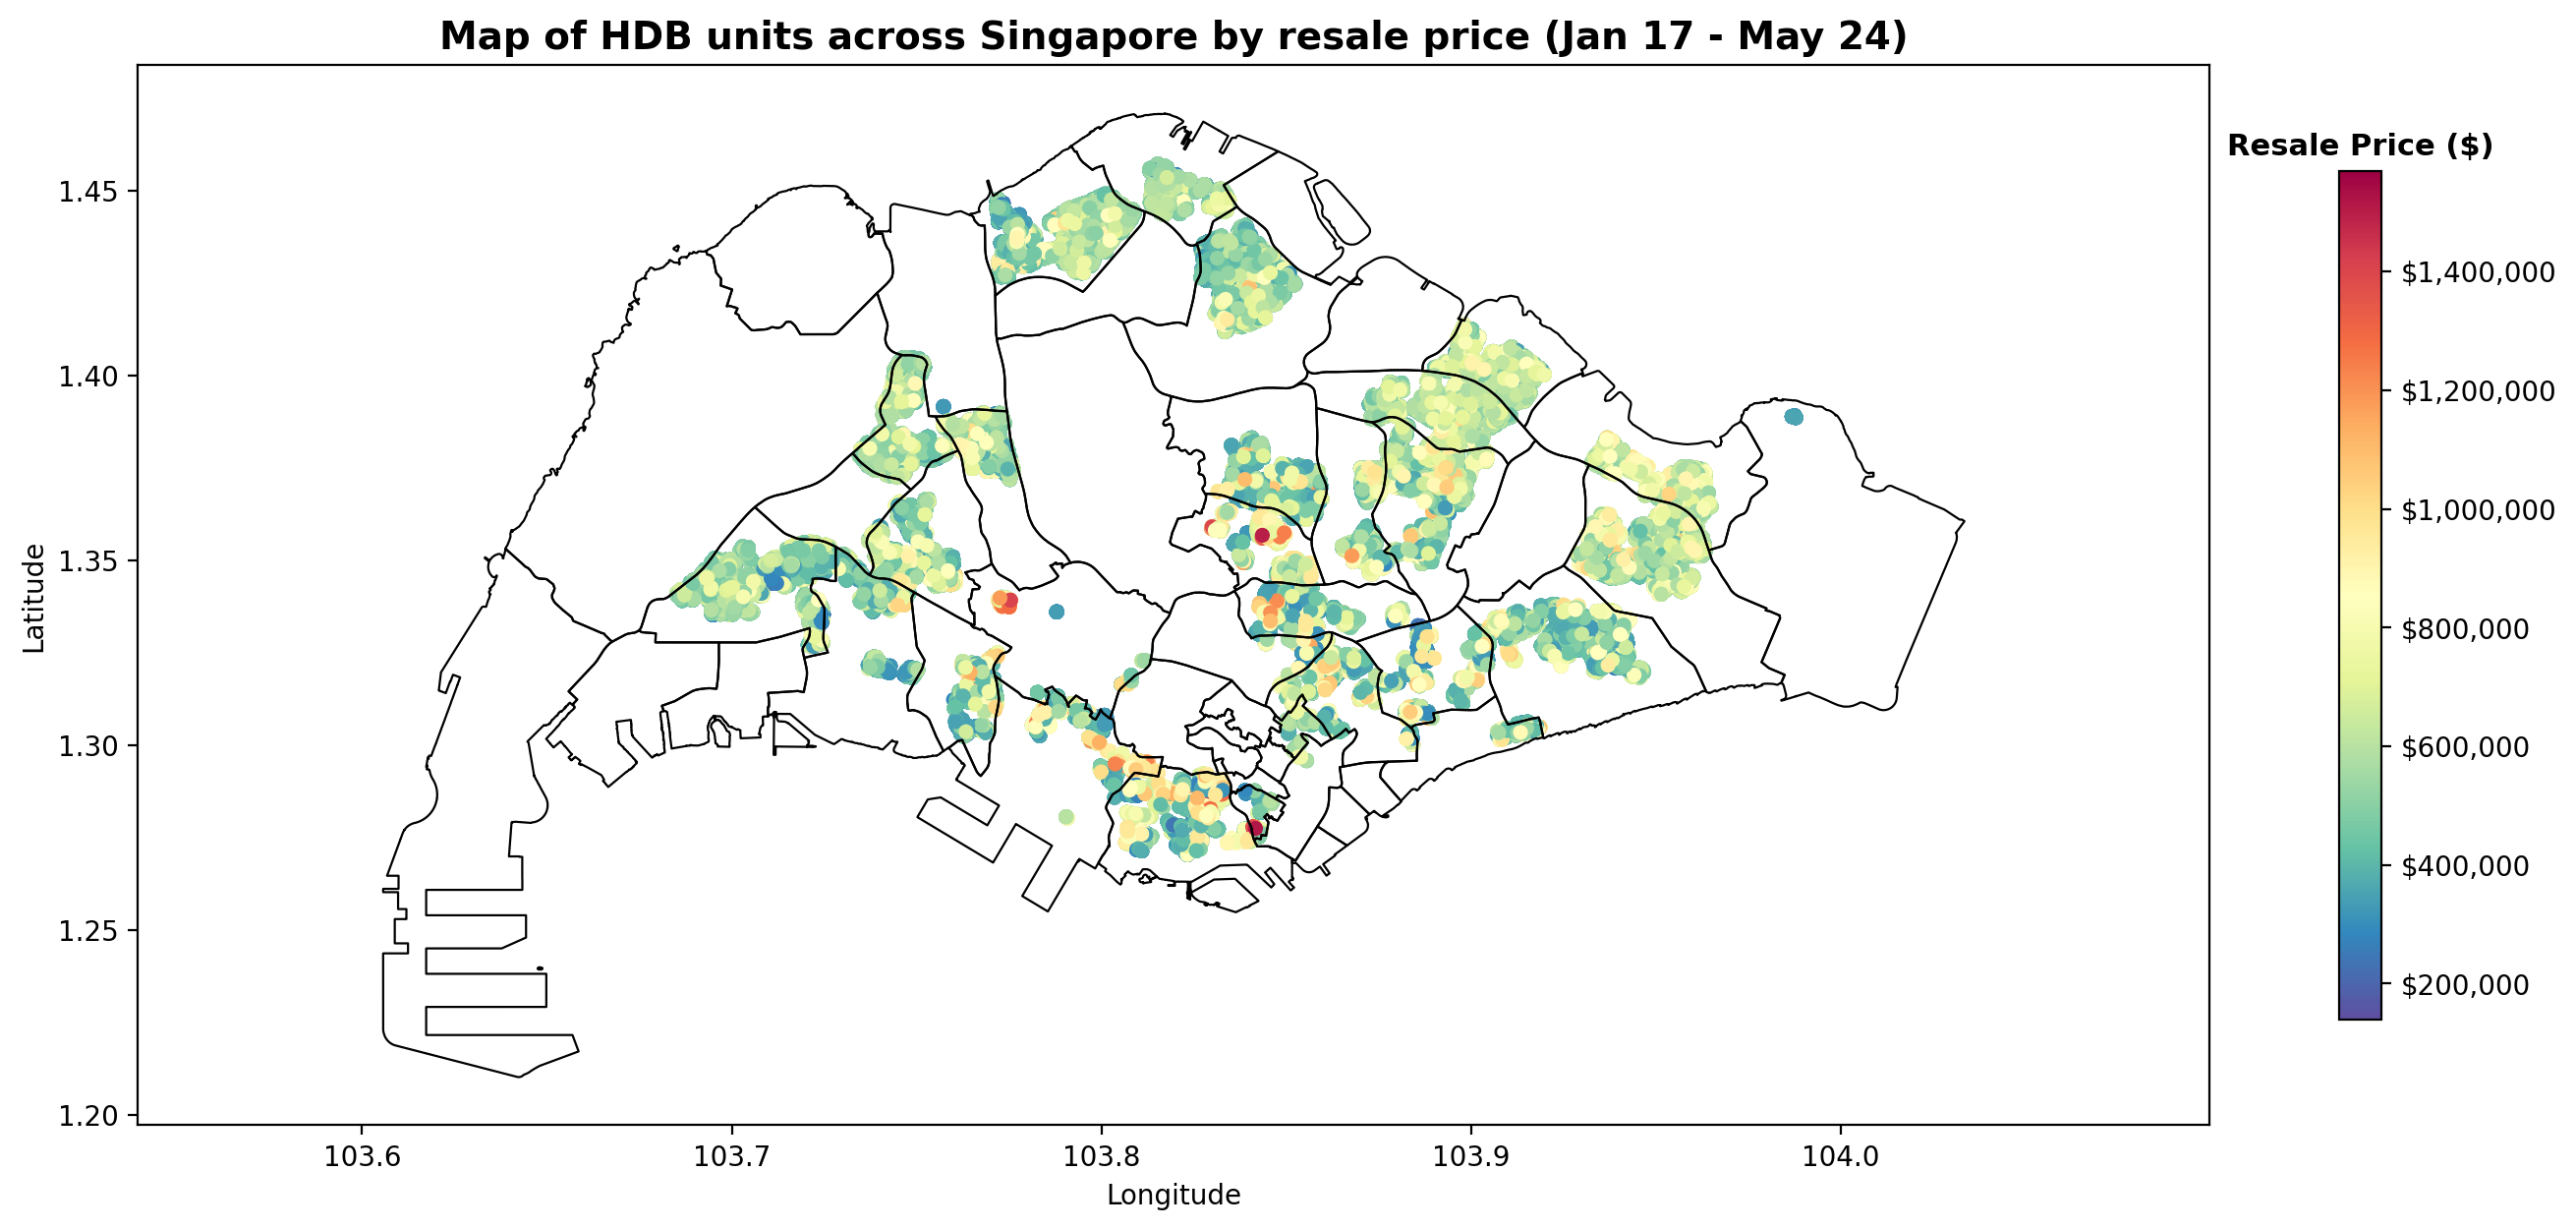

In [172]:
# Initiate figure
fig, ax = plt.subplots(figsize=(17,7))
plt.style.use('default')

# Scatterplot labels
plt.title('Map of HDB units across Singapore by resale price (Jan 17 - May 24)', fontweight='bold', fontsize=14)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# Plot basemap
sg_filtered.boundary.plot(edgecolor='black', ax=ax, linewidth=0.8)

# Plot location of resale HDB units with resale price as colour gradient
ax.scatter(x=longitude, y=latitude, c=resale['resale_price'], cmap='Spectral_r', s=20)

# Set equal axis for scaling
ax.axis('equal')

# Colour bar for to display resale price gradient, map colourmap and normalise range of values (min-max resale price) for colour mapping 
cmap = mpl.cm.Spectral_r
norm = mpl.colors.Normalize(vmin=np.min(resale['resale_price']), vmax=np.max(resale['resale_price']))

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='right', shrink=0.8, pad=0.05)

# Format colour bar
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
cbar.ax.set_title('Resale Price ($)', fontsize=11, fontweight='bold', horizontalalignment='center')

# Show scatterplot
plt.show()

In addition to observing the temporal price distribution across room types, the resale price dataset offers a more detailed spatial overview of resale options by mapping the geocoordinates of each resale flat (geocoded from their addresses) and colour-coding them according to their resale price. <br>

The priciest resale flats tend to cluster in mature estates nearer to the city center, such as Bishan, Tanjong Pagar, Bukit Merah, and Bukit Timah. <br>

In contrast, more affordable flats are situated in heartlands and non-mature estates like Woodlands, Yishun, and Jurong.

# 2.3. BTO or Resale? <a id = '2_3'></a>

Combining the analyses of BTOs and resale flats allows for a more comprehensive evaluation of both options, facilitating a better-informed decision-making process. By comparing the prices of BTOs and resale flats side by side, prospective buyers can weigh the advantages and disadvantages of each option and determine which aligns better with their preferences, budget, and timeline.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


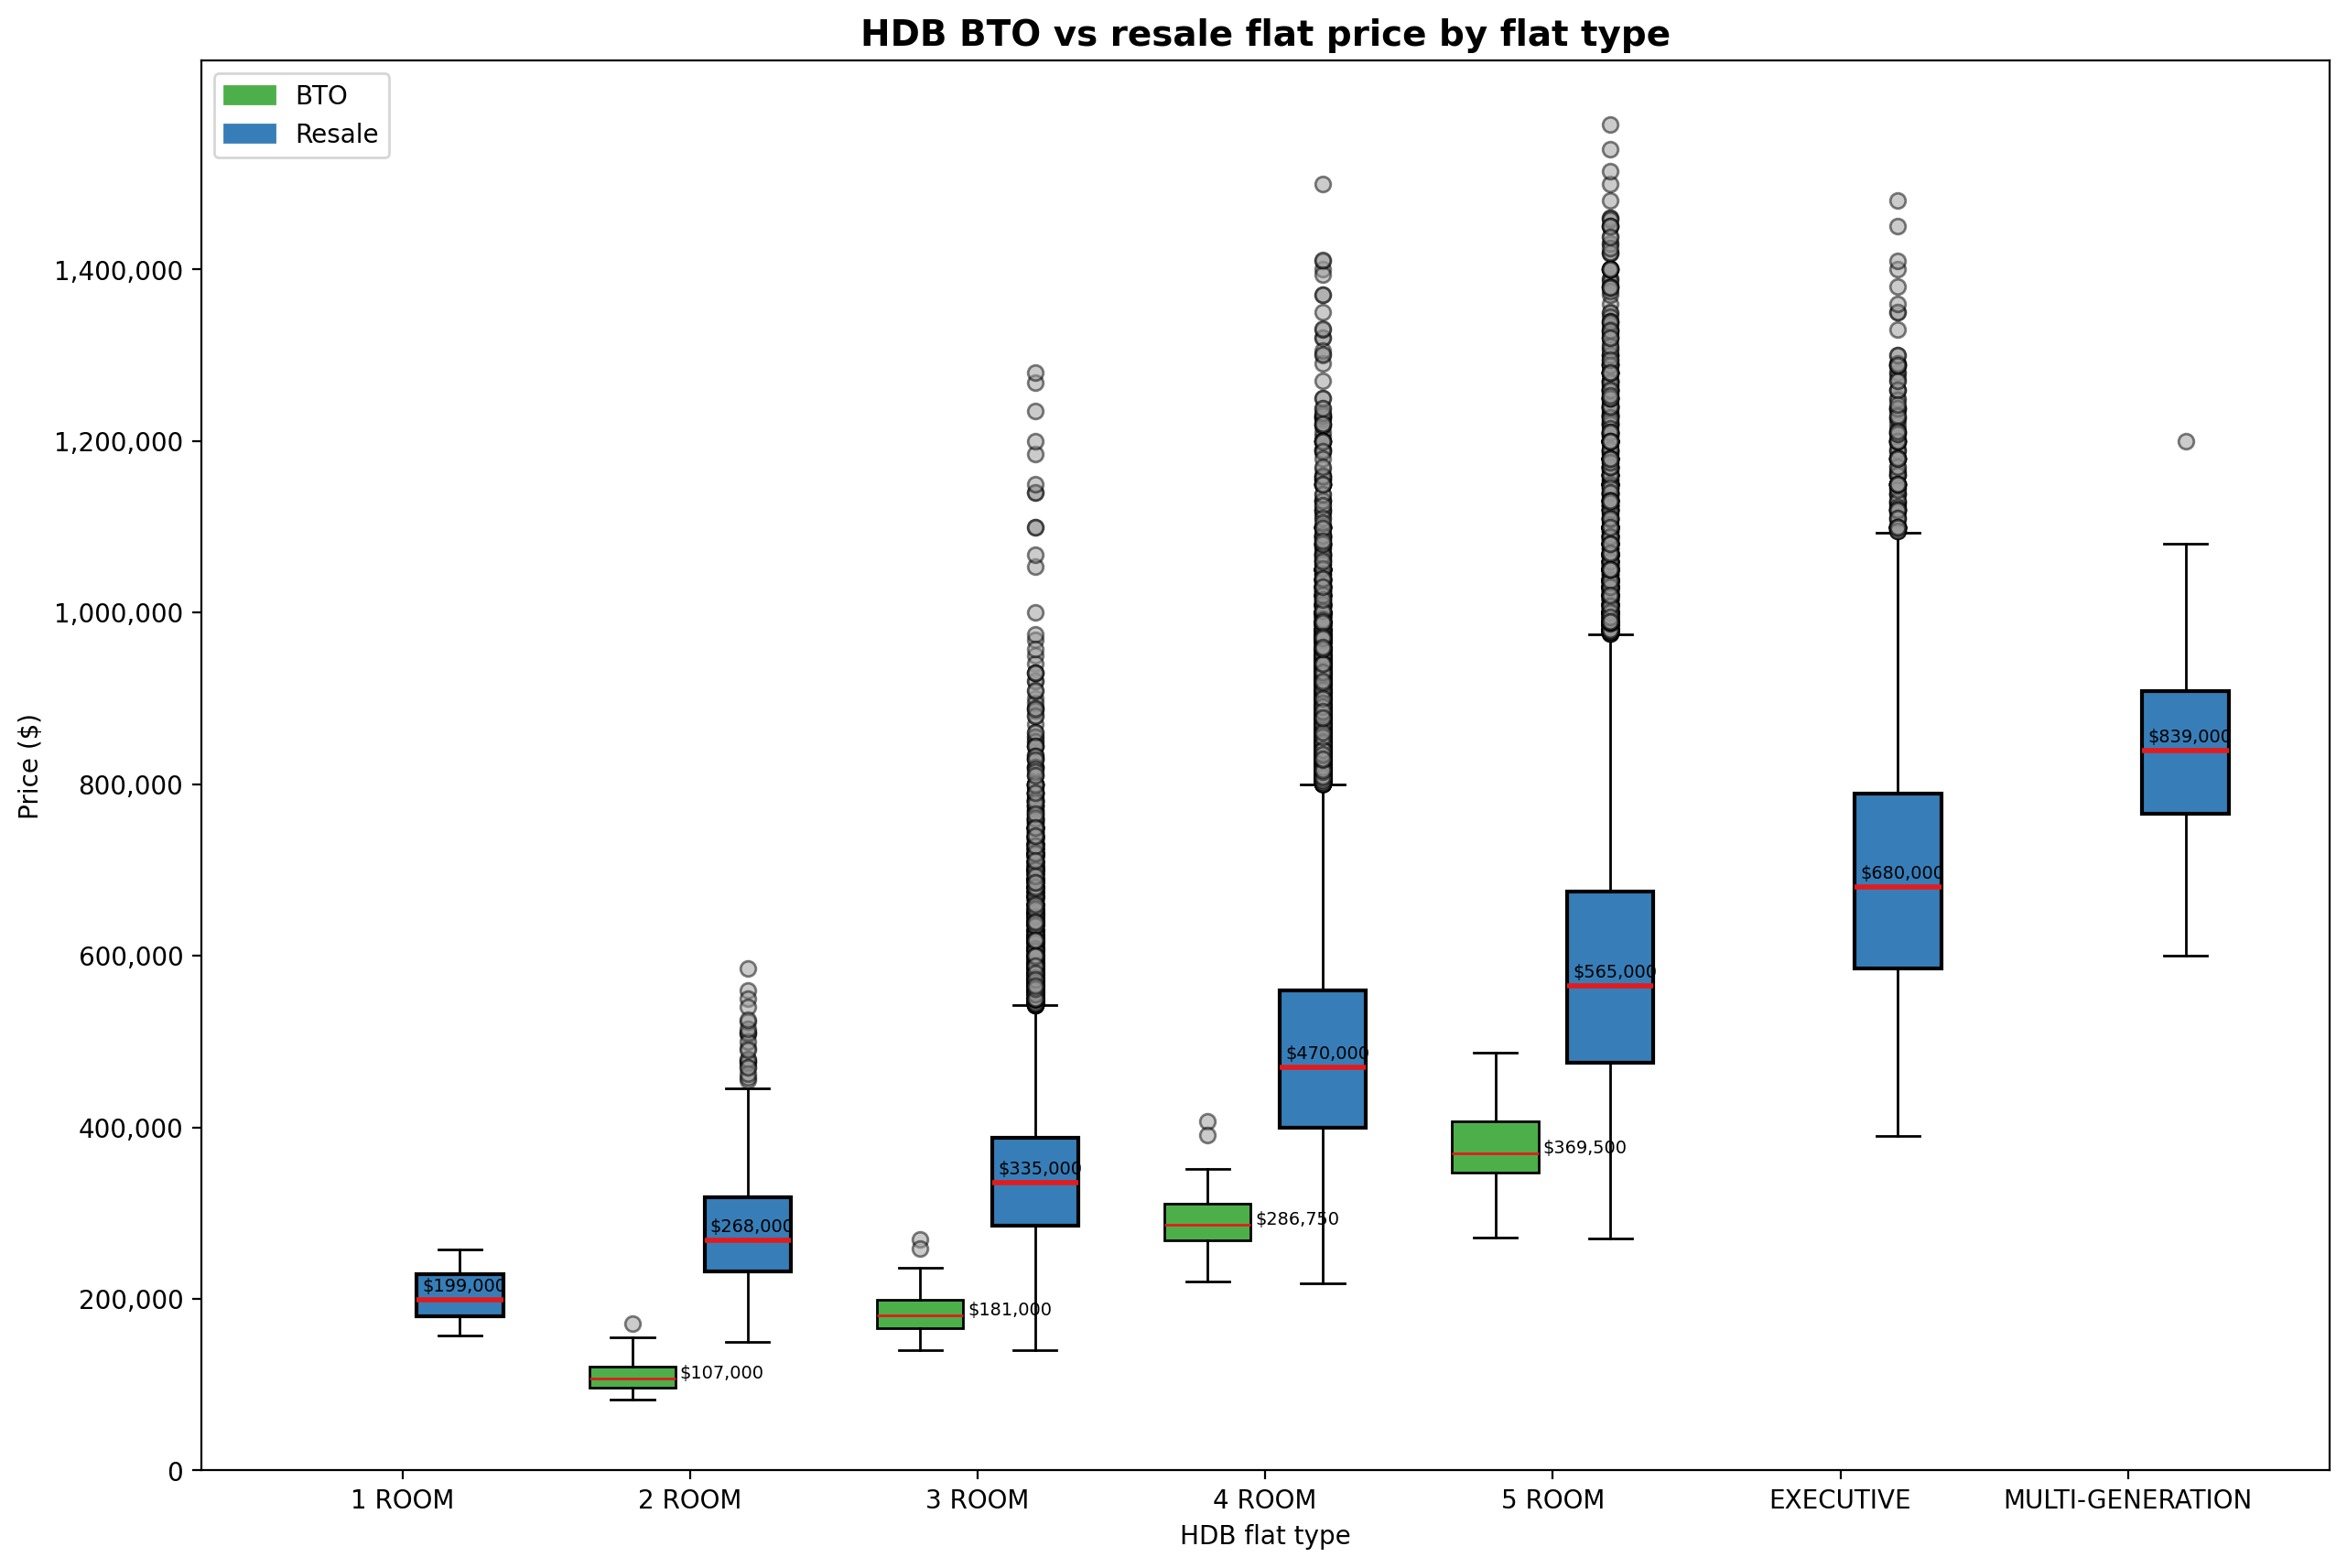

In [173]:
# Store resale price values for each flat type as a list of arrays
resale_price_combined = []
for flat_type in flat_types:
    resale_price_combined.append(resale[resale['flat_type'] == flat_type]['resale_price'])

# Store BTO price values for each flat type as a list of arrays
bto_price_combined = []
for room_type in flat_types:
    bto_room_type_cleaned = np.char.upper(np.char.replace(bto['room_type'], '-', ' '))
    bto_price_combined.append(bto[bto_room_type_cleaned == room_type]['average_selling_price'])


# Initiate figure
plt.figure(figsize=(15,10))
plt.style.use('default')

# Boxplot labels
plt.title('HDB BTO vs resale flat price by flat type', fontweight='bold', fontsize=14)
plt.ylabel('Price ($)')
plt.xlabel('HDB flat type')

# Define offset
box_offset = np.arange(len(resale_price_combined))

# Create boxplot objects
bp_bto = plt.boxplot(bto_price_combined, positions=np.arange(len(flat_types))-0.2, widths=0.3, patch_artist=True)
bp_resale = plt.boxplot(resale_price_combined, positions=np.arange(len(flat_types))+0.2, widths=0.3, patch_artist=True)

# Boxplot ticks and tick labels
plt.yticks(np.arange(0,1600000, 200000), ['{:,}'.format(i) for i in np.arange(0,1600000, 200000)])
plt.xticks(np.arange(len(flat_types)), flat_types)

# Create legend handles since boxplots do not have explicit artists (plot elements with labels)
bto_patch = mpatches.Patch(color='#4daf4a', label='BTO')
resale_patch = mpatches.Patch(color='#377eb8', label='Resale')

# Add legend with defined handles
plt.legend(handles=[bto_patch, resale_patch], loc='upper left')


##### BTO BOXPLOT CUSTOMISATION #####
# Customise boxplot
for box in bp_bto['boxes']:
    box.set(color='black', linewidth=1)
    box.set(facecolor='#4daf4a')

for median in bp_bto['medians']:
    median.set(color='#e41a1c', linewidth=1)

for flier in bp_bto['fliers']:
    flier.set(marker='o', markerfacecolor='#999999', alpha=0.5)

# Dsiplay median values as text for each flat type
for line in bp_bto['medians']:
    # Get coordinates of each median line
    x, y = line.get_xydata()[0]
    # Format and print
    plt.text(x+0.315, y, '${:,.0f}'.format(y), size = 'x-small') # shows warning message for room types that do not exist in BTO dataset (i.e., NA)


##### RESALE BOXPLOT CUSTOMISATION #####
# Customise boxplot
for box in bp_resale['boxes']:
    box.set(color='black', linewidth=1.5)
    box.set(facecolor='#377eb8')

for median in bp_resale['medians']:
    median.set(color='#e41a1c', linewidth=2)

for flier in bp_resale['fliers']:
    flier.set(marker='o', markerfacecolor='#999999', alpha=0.5)

# Dsiplay median values as text for each flat type
for line in bp_resale['medians']:
    # Get coordinates of each median line
    x, y = line.get_xydata()[0]
    # Format and print
    plt.text(x+0.02, y+10000, '${:,.0f}'.format(y), size = 'x-small')


# Show boxplot
plt.show()

The above graph illustrates the price differences between BTOs and resale flats. <br>

Immediately, it is noticeable that resale flats are markedly more expensive compared to BTO units for the same room type. This discrepancy could be attributed to the extended wait periods (typically 4-5 years or longer) for BTO project completion and buyers' readiness to pay a premium for immediate possession. <br>

In such circumstances, buyers with budget constraints might find BTOs a more feasible option, albeit with the trade-off of enduring longer waiting periods. Alternatively, those seeking immediate occupancy would need to prepare to pay a premium upwards of at least $50,000 for a resale flat.

## 2.4. HDB grants by year <a id = '2_4'></a>

Given the high costs of public housing in Singapore, housing grants can potentially offset the costs of housing considerably. Here, the CPF housing grants dataset was examined to gain insight in the types and number of grants disbursed from 2010 to 2022.

__Load data__

In [11]:
# Read data and fill NA where applicable
grants = np.genfromtxt('../02_Data/CPFHousingGrantsAwardedbyType.csv', delimiter=',', skip_header=1, 
                       dtype=[('financial_year', 'u8'), ('housing_grant_scheme', 'U50'), ('type_of_grant', 'U50'), ('no_of_hh', 'i8')], 
                       missing_values=['na'], filling_values=0)

# I prefer caps NA so replace values accordingly
grants['type_of_grant'][grants['type_of_grant'] == 'na'] = 'NA'

# View first 5 rows
grants[:5]

array([(2010, 'CPF Housing Grant', 'Family Grant (living near parents/married child)',  2249),
       (2010, 'CPF Housing Grant', 'Family Grant',  4198),
       (2010, 'CPF Housing Grant', 'Singles Grant',   926),
       (2010, 'CPF Housing Grant', 'Joint Singles Grant',    59),
       (2010, 'Additional CPF Housing Grant', 'NA', 10307)],
      dtype=[('financial_year', '<u8'), ('housing_grant_scheme', '<U50'), ('type_of_grant', '<U50'), ('no_of_hh', '<i8')])

In [12]:
print('***** Data Inspection *****\n')

# Check for correct number of years
print('*** Check for duplicate years ***')
print(f"{np.unique(grants['financial_year'])}\n")

# Check for duplicates of grant schemes
print('*** Check for duplicate housing grant schemes ***')
print(f"{np.unique(grants['housing_grant_scheme'])}\n")

# Check for duplicates of type of grants
print('*** Check for duplicate grant types ***')
print(f"{np.unique(grants['type_of_grant'])}")

***** Data Inspection *****

*** Check for duplicate years ***
[2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]

*** Check for duplicate housing grant schemes ***
['Additional CPF Housing Grant' 'CPF Housing Grant'
 'Proximity Housing Grant' 'Special CPF Housing Grant']

*** Check for duplicate grant types ***
['Family Grant' 'Family Grant (living near parents/married child)'
 'Joint Singles Grant' 'NA' 'Singles Grant'
 'Singles Grant (living with parents)']


__Descriptive stats__

In [13]:
# Define variables for header print
header = ' CPF housing grants disbursed from 2010 to 2022 '
grants_len = len(grants)

# Print header
print(f'{header:*^{len(header)+10}}')

# Print number of rows in dataset
print(f'There are a total of {grants_len:,} rows in this dataset')

# Get unique grant schemes
grant_schemes = np.unique(grants['housing_grant_scheme'])
years = np.unique(grants['financial_year'])

# Descriptive stats for each grant scheme
print(f'Within this dataset, there are {len(grant_schemes)} different housing grant schemes: {*grant_schemes,}')

***** CPF housing grants disbursed from 2010 to 2022 *****
There are a total of 95 rows in this dataset
Within this dataset, there are 4 different housing grant schemes: ('Additional CPF Housing Grant', 'CPF Housing Grant', 'Proximity Housing Grant', 'Special CPF Housing Grant')


__`Line plot` of number of grants disbursed each year__

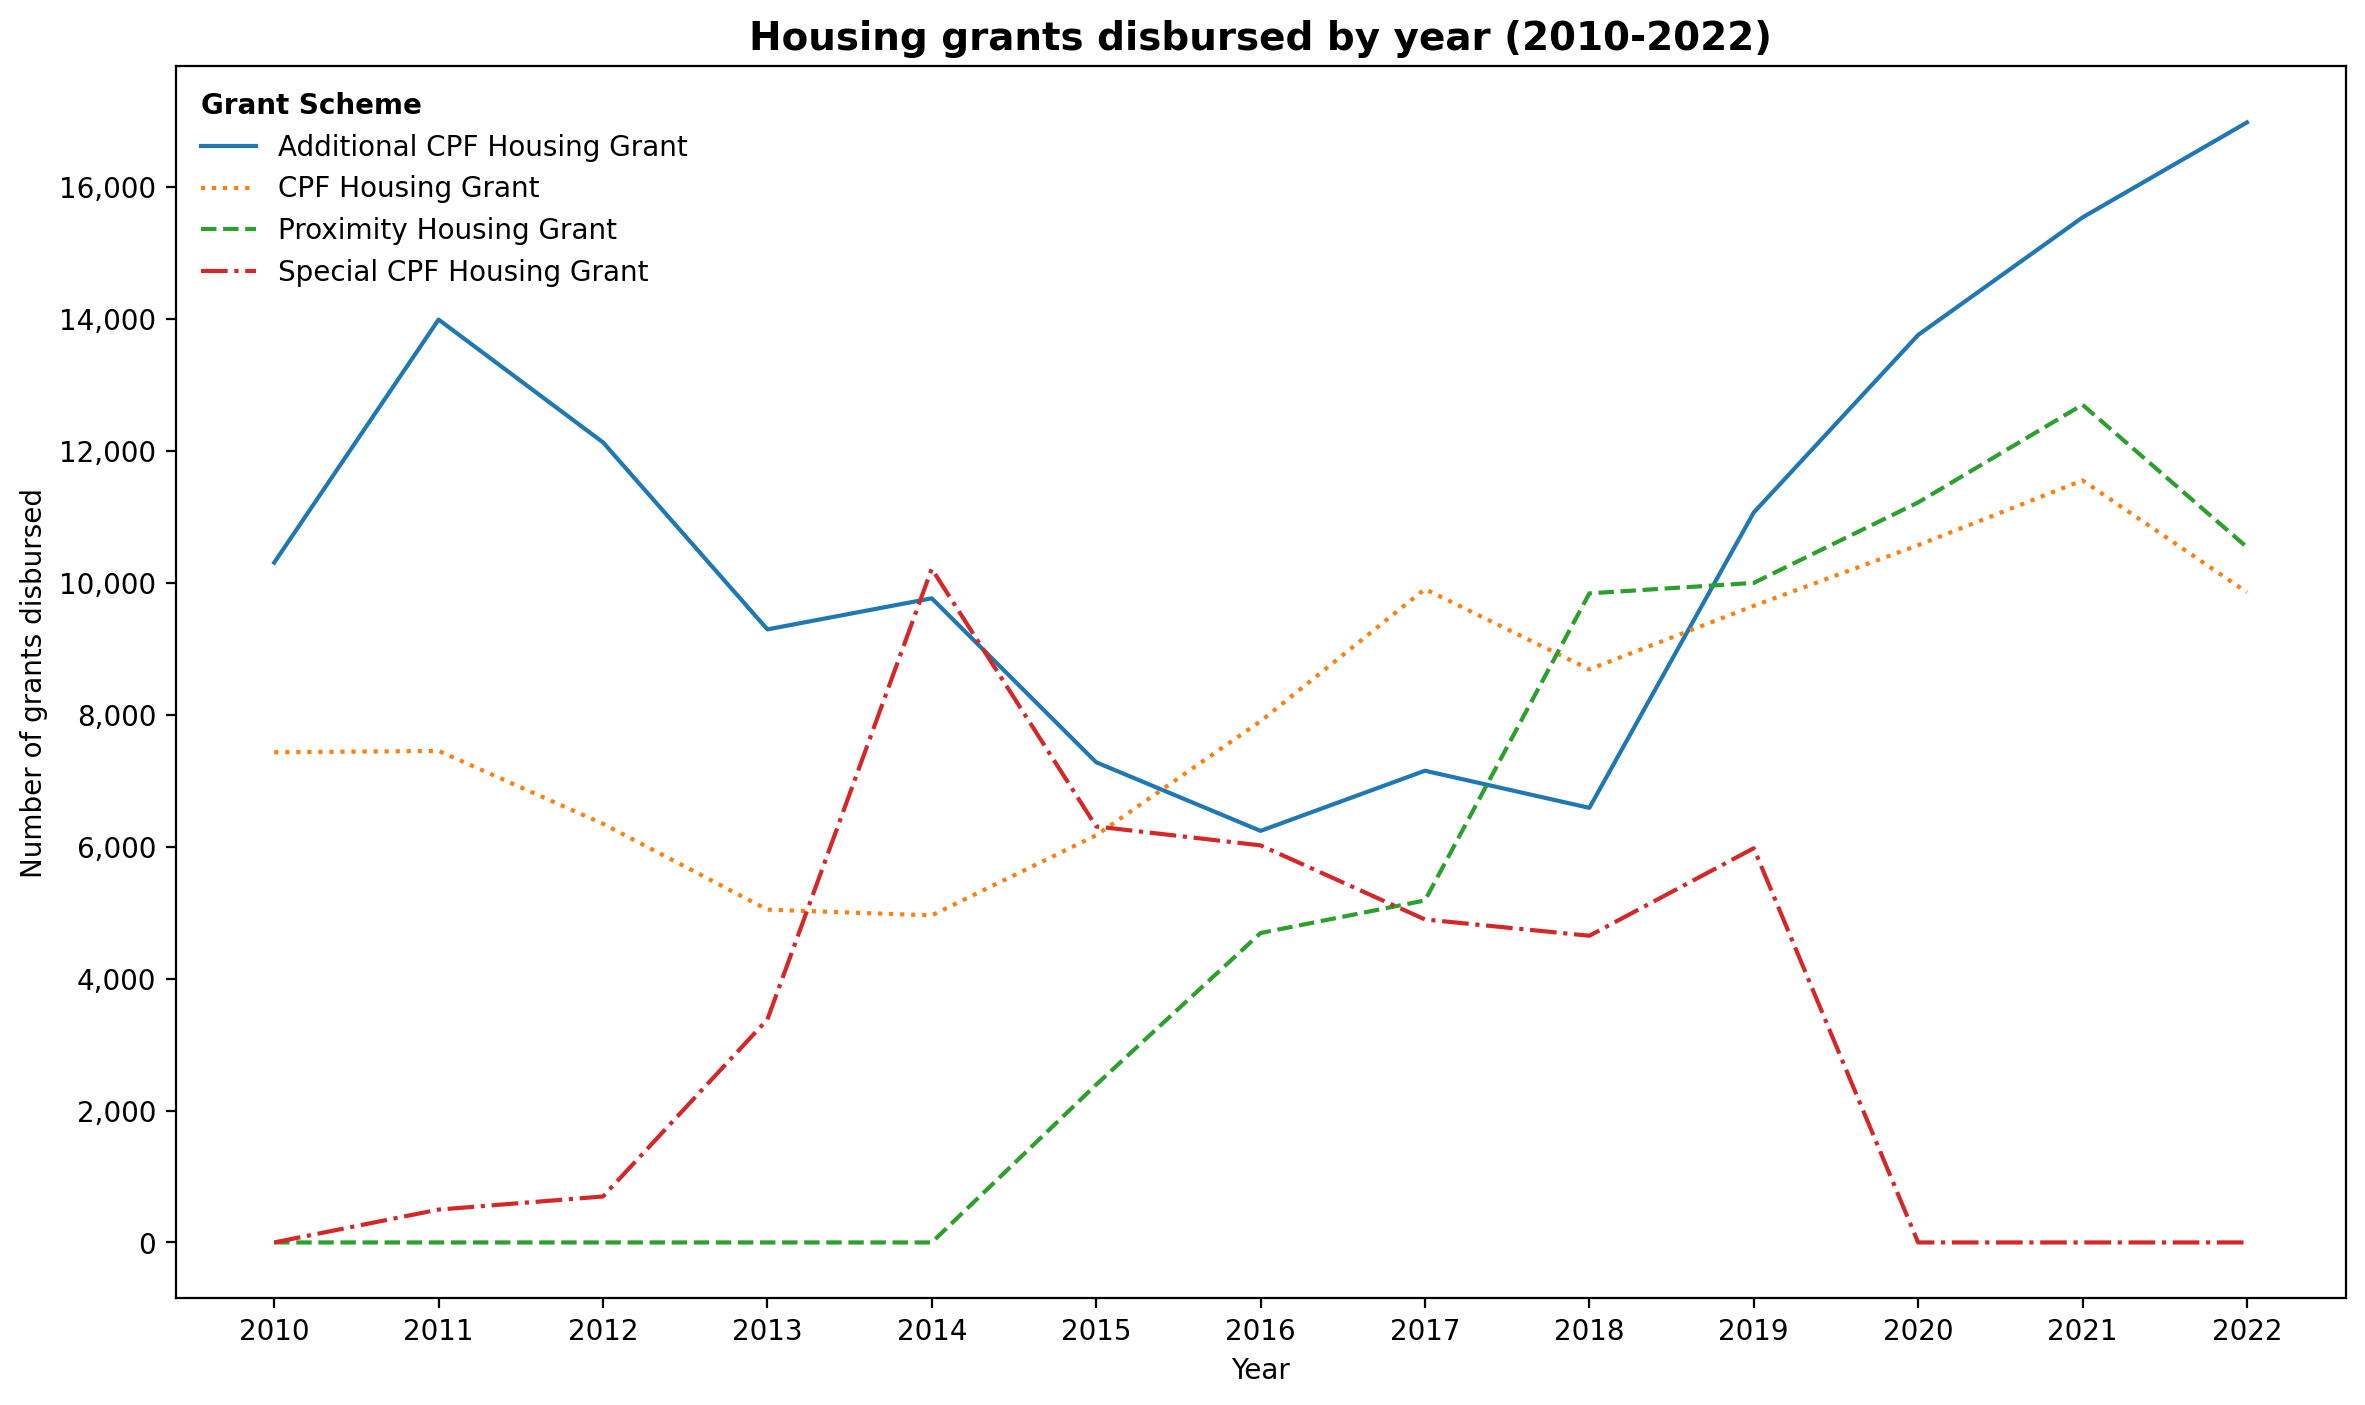

In [14]:
# Store total number of grant each year for each grant scheme as a list of arrays
hh_by_grant = []

# Iterate through each grant scheme: one grant scheme = one array
for grant in grant_schemes:
    hh_sum = []
    # Iterate through each year and sum total number of grants disbursed for the grant scheme
    for year in years:
        hh_sum.append(np.sum(grants[(grants['financial_year'] == year) & (grants['housing_grant_scheme'] == grant)]['no_of_hh']))
    # Append array of grant schemes disbursed for each year to hh_by_grant list
    hh_by_grant.append(np.array(hh_sum))

# Initiate figure
plt.figure(figsize=(14,8))
plt.style.use('default')

# Line plot labels
plt.title('Housing grants disbursed by year (2010-2022)', fontweight='bold', fontsize=14)
plt.ylabel('Number of grants disbursed')
plt.xlabel('Year')

# Line plot ticks and tick labels
plt.xticks(np.arange(2010,2023))
plt.yticks(np.arange(0,21000,2000), ['{:,}'.format(i) for i in np.arange(0,21000,2000)])

# Define colours for each grant scheme
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
linestyles = ['solid', 'dotted', 'dashed', 'dashdot']

# Separate lines for each grant scheme
for i in range(len(hh_by_grant)):
    plt.plot(years, hh_by_grant[i], label=grant_schemes[i], c=colours[i], linestyle=linestyles[i])

# Legend
plt.legend(grant_schemes, frameon=False, loc='upper left', title='Grant Scheme', title_fontproperties={'weight': 'bold'}, alignment='left')

# Show boxplot
plt.show()

The trending of the CPF grant time series offers valuable insights for prospective homeowners in 2024, providing reassurance regarding the accessibility and probability of receiving grants to mitigate housing expenses. <br>

Over the period from 2010 to 2022, there us a consistent increase in the distribution of additional CPF housing grants, CPF housing grants, and proximity housing grants by HDB. However, there's a distinct decline in the allocation of special CPF housing grants, which eventually ceased entirely from 2020 onwards. This observation is consistent with HDB's housing policy where the special CPF housing grant was phased out in 2020.

## 2.5. HDB Financial Assistance Measures (FAM) <a id = '2_5'></a>

In addition to housing grants, financial assistance measures are crucial for households needing further financial support or those ineligible for grant assistance. The HDB FAM dataset was analysed to provide insight on the likelihood of securing HDB's FAM and the general availability of supplementary financial aid.

__Load data__

In [7]:
# Read data
fam = np.genfromtxt('../02_Data/Numberofapprovedapplicationsforfinancialassistancemeasuresbyfinancialyear.csv', delimiter=',', skip_header=1, 
                    dtype=[('financial_year', 'u8'), ('no_of_approvals', 'i8')],
                    missing_values=['na'], filling_values=0)

# View first 5 rows
fam[:5]

array([(2008, 5326), (2009, 6340), (2010, 4407), (2011, 3262),
       (2012, 4115)],
      dtype=[('financial_year', '<u8'), ('no_of_approvals', '<i8')])

In [8]:
print('***** Data Inspection *****\n')

# Check for correct number of years
print('*** Check for duplicate years ***')
print(f"{fam['financial_year']}\n")

# Check values of applications
print('*** Inspect number of FAM applications since dataset is small ***')
print(f"{fam['no_of_approvals']}")

***** Data Inspection *****

*** Check for duplicate years ***
[2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021
 2022]

*** Inspect number of FAM applications since dataset is small ***
[5326 6340 4407 3262 4115 3058 2395 2531 2359 2401 3002 2698 5223 3644
 2179]


__`Bar plot` of FAM approvals by year__

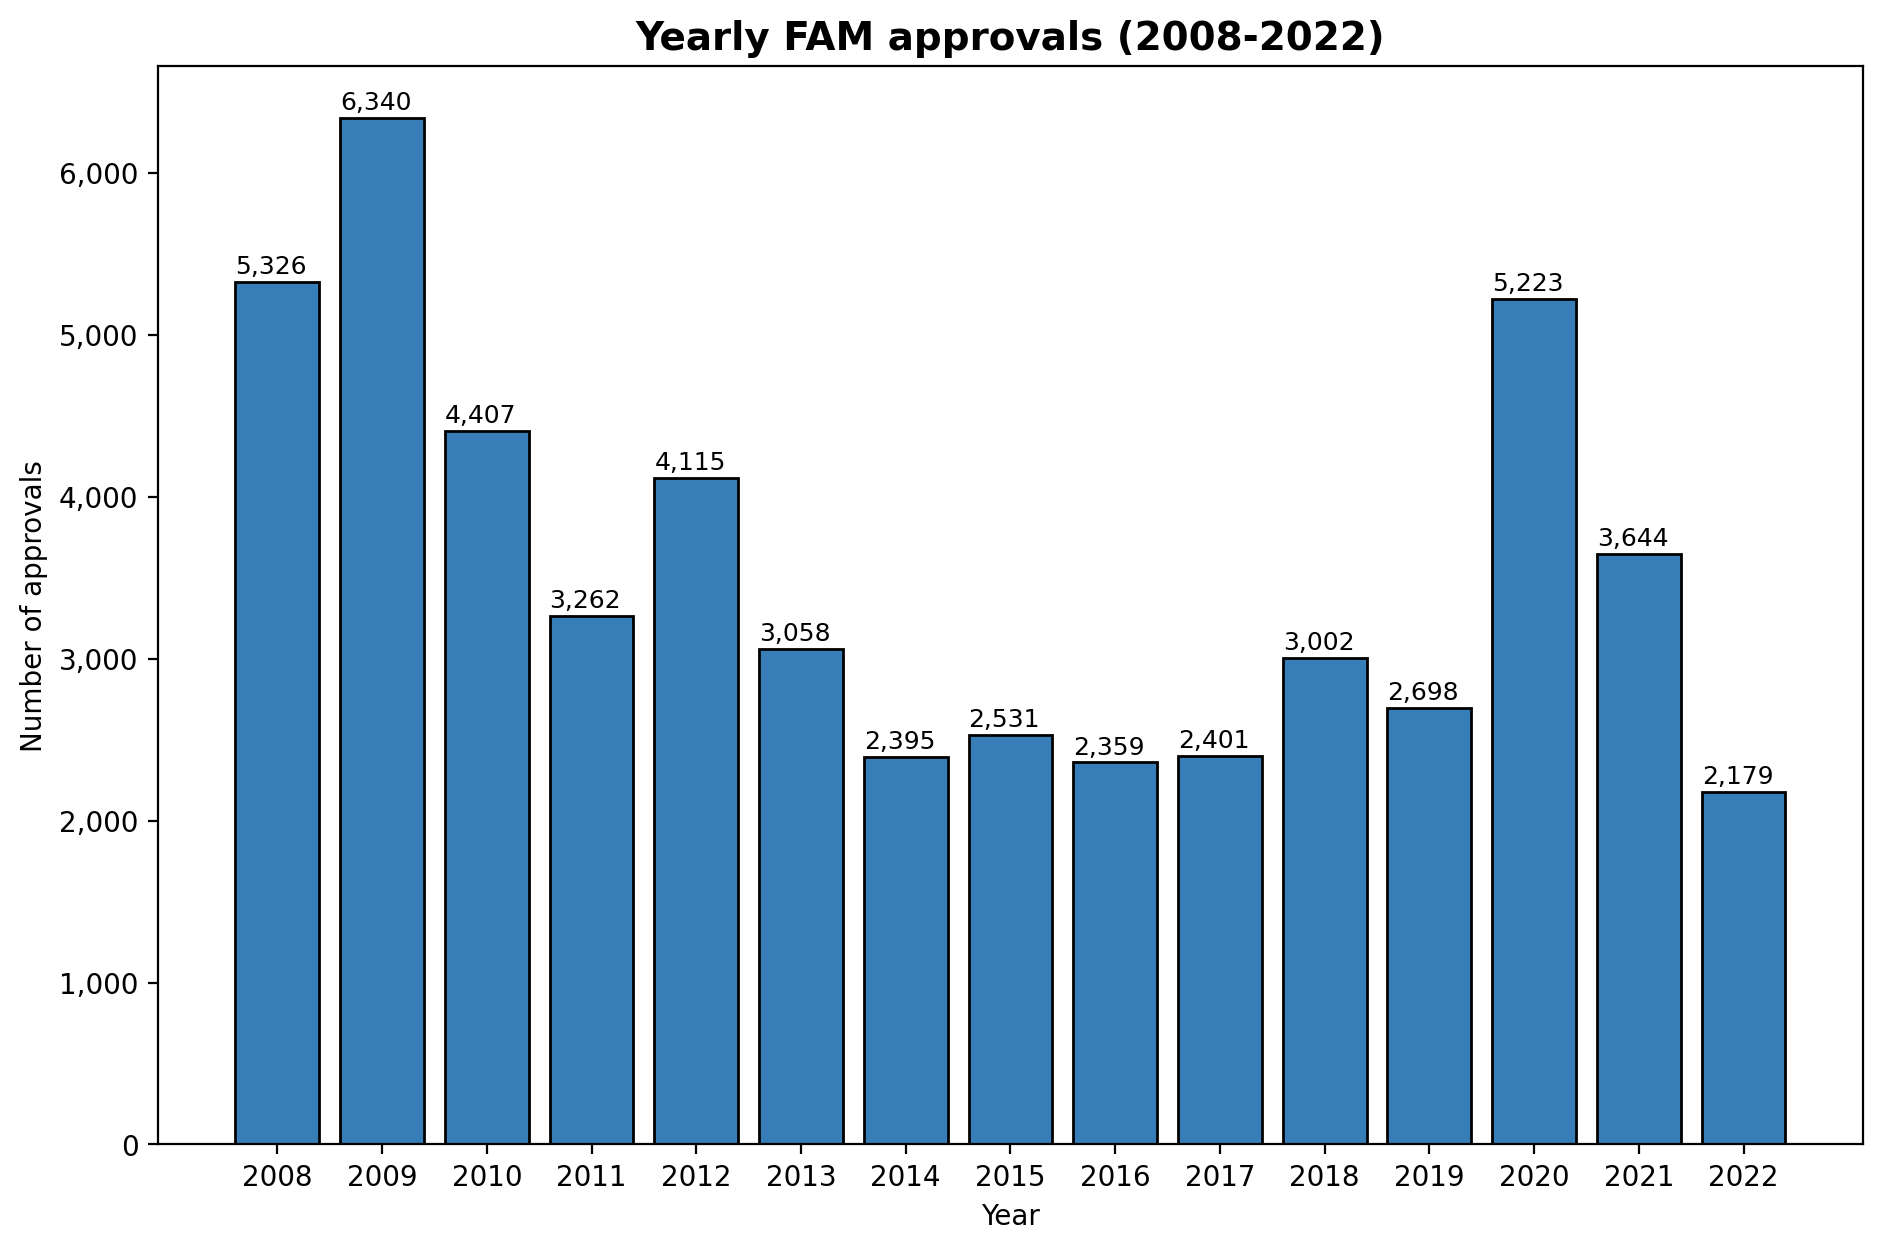

In [9]:
# Initiate figure
plt.figure(figsize=(11,7))
plt.style.use('default')

# Bar chart labels
plt.title('Yearly FAM approvals (2008-2022)', fontweight='bold', fontsize=14)
plt.ylabel('Number of approvals')
plt.xlabel('Year')

# Bar chart ticks and tick labels
plt.xticks(np.arange(2008,2023))
plt.yticks(np.arange(0,7000,1000), ['{:,}'.format(i) for i in np.arange(0,7000,1000)])

# Plot bar chart
barchart = plt.bar(fam['financial_year'], fam['no_of_approvals'], color='#377eb8', edgecolor='black')

# Show bar chart values for each year
for i in range(len(barchart)):
    bar = barchart[i]
    x, y = bar.get_xy()
    h = bar.get_height()
    plt.text(x, h+50, "{:,}".format(fam['no_of_approvals'][i]), fontsize=9)

# Show plot
plt.show()

The bar graph lends insight into the accessibility of HDB's Financial Assistance Measures (FAM) for buyers. <br>

FAM approvals showed a general decrease from 2008 to 2019, followed by a sharp increase in 2020, and then returning to normal levels by 2022. This decline over the years could be attributed to increased support for housing finances through HDB's housing grants, as illustrated in the previous graph, and the maturation of Singapore's economy leading to higher household incomes and reduced need for financial assistance. <br>

In comparison, the spike in 2020 can be attributed to the economic impact of COVID-19, which increased the demand for financial support for housing. <br>

Despite the overall decrease in FAM approvals, buyers can still reasonably expect the availability of financial support if needed for their housing needs.

## 2.6. HDB rental prices <a id = '2_6'></a>

As a last resort, home owners may look to rent a place of their own should they be unable to purchase a BTO or resale flat due to financial constraints. Hence, the HDB rental data from 2021 to 2024 was analysed to identity alternatives options.

__Load data__

In [24]:
# Read data and fill NA where applicable
rent = np.genfromtxt('../02_Data/RentingOutofFlats2024CSV.csv', delimiter=',', skip_header=1,
                     dtype=[('rent_approval_date', 'U50'), ('town', 'U50'), ('block', 'U10'),
                            ('street_name', 'U50'), ('flat_type', 'U50'), ('monthly_rent', 'i8')],
                    missing_values=['na'], filling_values=0)

# View first 5 rows
rent[:5]

array([('2021-01', 'ANG MO KIO', '105', 'ANG MO KIO AVE 4', '4-ROOM', 2000),
       ('2021-01', 'ANG MO KIO', '107', 'ANG MO KIO AVE 4', '3-ROOM', 1750),
       ('2021-01', 'ANG MO KIO', '108', 'ANG MO KIO AVE 4', '3-ROOM', 1750),
       ('2021-01', 'ANG MO KIO', '111', 'ANG MO KIO AVE 4', '5-ROOM', 2230),
       ('2021-01', 'ANG MO KIO', '111', 'ANG MO KIO AVE 4', '5-ROOM', 2450)],
      dtype=[('rent_approval_date', '<U50'), ('town', '<U50'), ('block', '<U10'), ('street_name', '<U50'), ('flat_type', '<U50'), ('monthly_rent', '<i8')])

In [25]:
print('***** Data Inspection *****\n')

# Check for correct number of years
print('*** Check for duplicate months ***')
print(f"{np.unique(rent['rent_approval_date'])}\n")

# Check for duplicates of towns
print('*** Check for duplicate towns ***')
print(f"{np.unique(rent['town'])}\n")

# Check for duplicates of room types
print('*** Check for duplicate flat types ***')
print(f"{np.unique(rent['flat_type'])}")

***** Data Inspection *****

*** Check for duplicate months ***
['2021-01' '2021-02' '2021-03' '2021-04' '2021-05' '2021-06' '2021-07'
 '2021-08' '2021-09' '2021-10' '2021-11' '2021-12' '2022-01' '2022-02'
 '2022-03' '2022-04' '2022-05' '2022-06' '2022-07' '2022-08' '2022-09'
 '2022-10' '2022-11' '2022-12' '2023-01' '2023-02' '2023-03' '2023-04'
 '2023-05' '2023-06' '2023-07' '2023-08' '2023-09' '2023-10' '2023-11'
 '2023-12' '2024-01' '2024-02' '2024-03' '2024-04']

*** Check for duplicate towns ***
['ANG MO KIO' 'BEDOK' 'BISHAN' 'BUKIT BATOK' 'BUKIT MERAH' 'BUKIT PANJANG'
 'BUKIT TIMAH' 'CENTRAL' 'CHOA CHU KANG' 'CLEMENTI' 'GEYLANG' 'HOUGANG'
 'JURONG EAST' 'JURONG WEST' 'KALLANG/WHAMPOA' 'MARINE PARADE' 'PASIR RIS'
 'PUNGGOL' 'QUEENSTOWN' 'SEMBAWANG' 'SENGKANG' 'SERANGOON' 'TAMPINES'
 'TOA PAYOH' 'WOODLANDS' 'YISHUN']

*** Check for duplicate flat types ***
['1-ROOM' '2-ROOM' '3-ROOM' '4-ROOM' '5-ROOM' 'EXECUTIVE']


__`Scatterplot` of monthly rent by location__

In [26]:
# Concatenate block and street name to get full address
address = []

for i in range(len(rent)):
    block_street_name = rent[i]['block'] + ' ' + rent[i]['street_name']
    address.append(block_street_name)

# Get unique address to reduce number of API calls
unique_address = np.unique(address)

# Geocode full address to obtain latitude and longitude coordinates stored in dictionary
# Pre-defined function used in helperFunc module, returns dict of latitude and longitude for each address
# address_dict_2 = get_coordinates(unique_address)

# Magic function to store address_dict for easy retrieval should kernel be restarted
%store -r address_dict_2

In [27]:
# Retrieve address details for each record in original address array
latitude_2 = [address_dict_2[i]['latitude'] for i in address]
longitude_2 = [address_dict_2[i]['longitude'] for i in address]

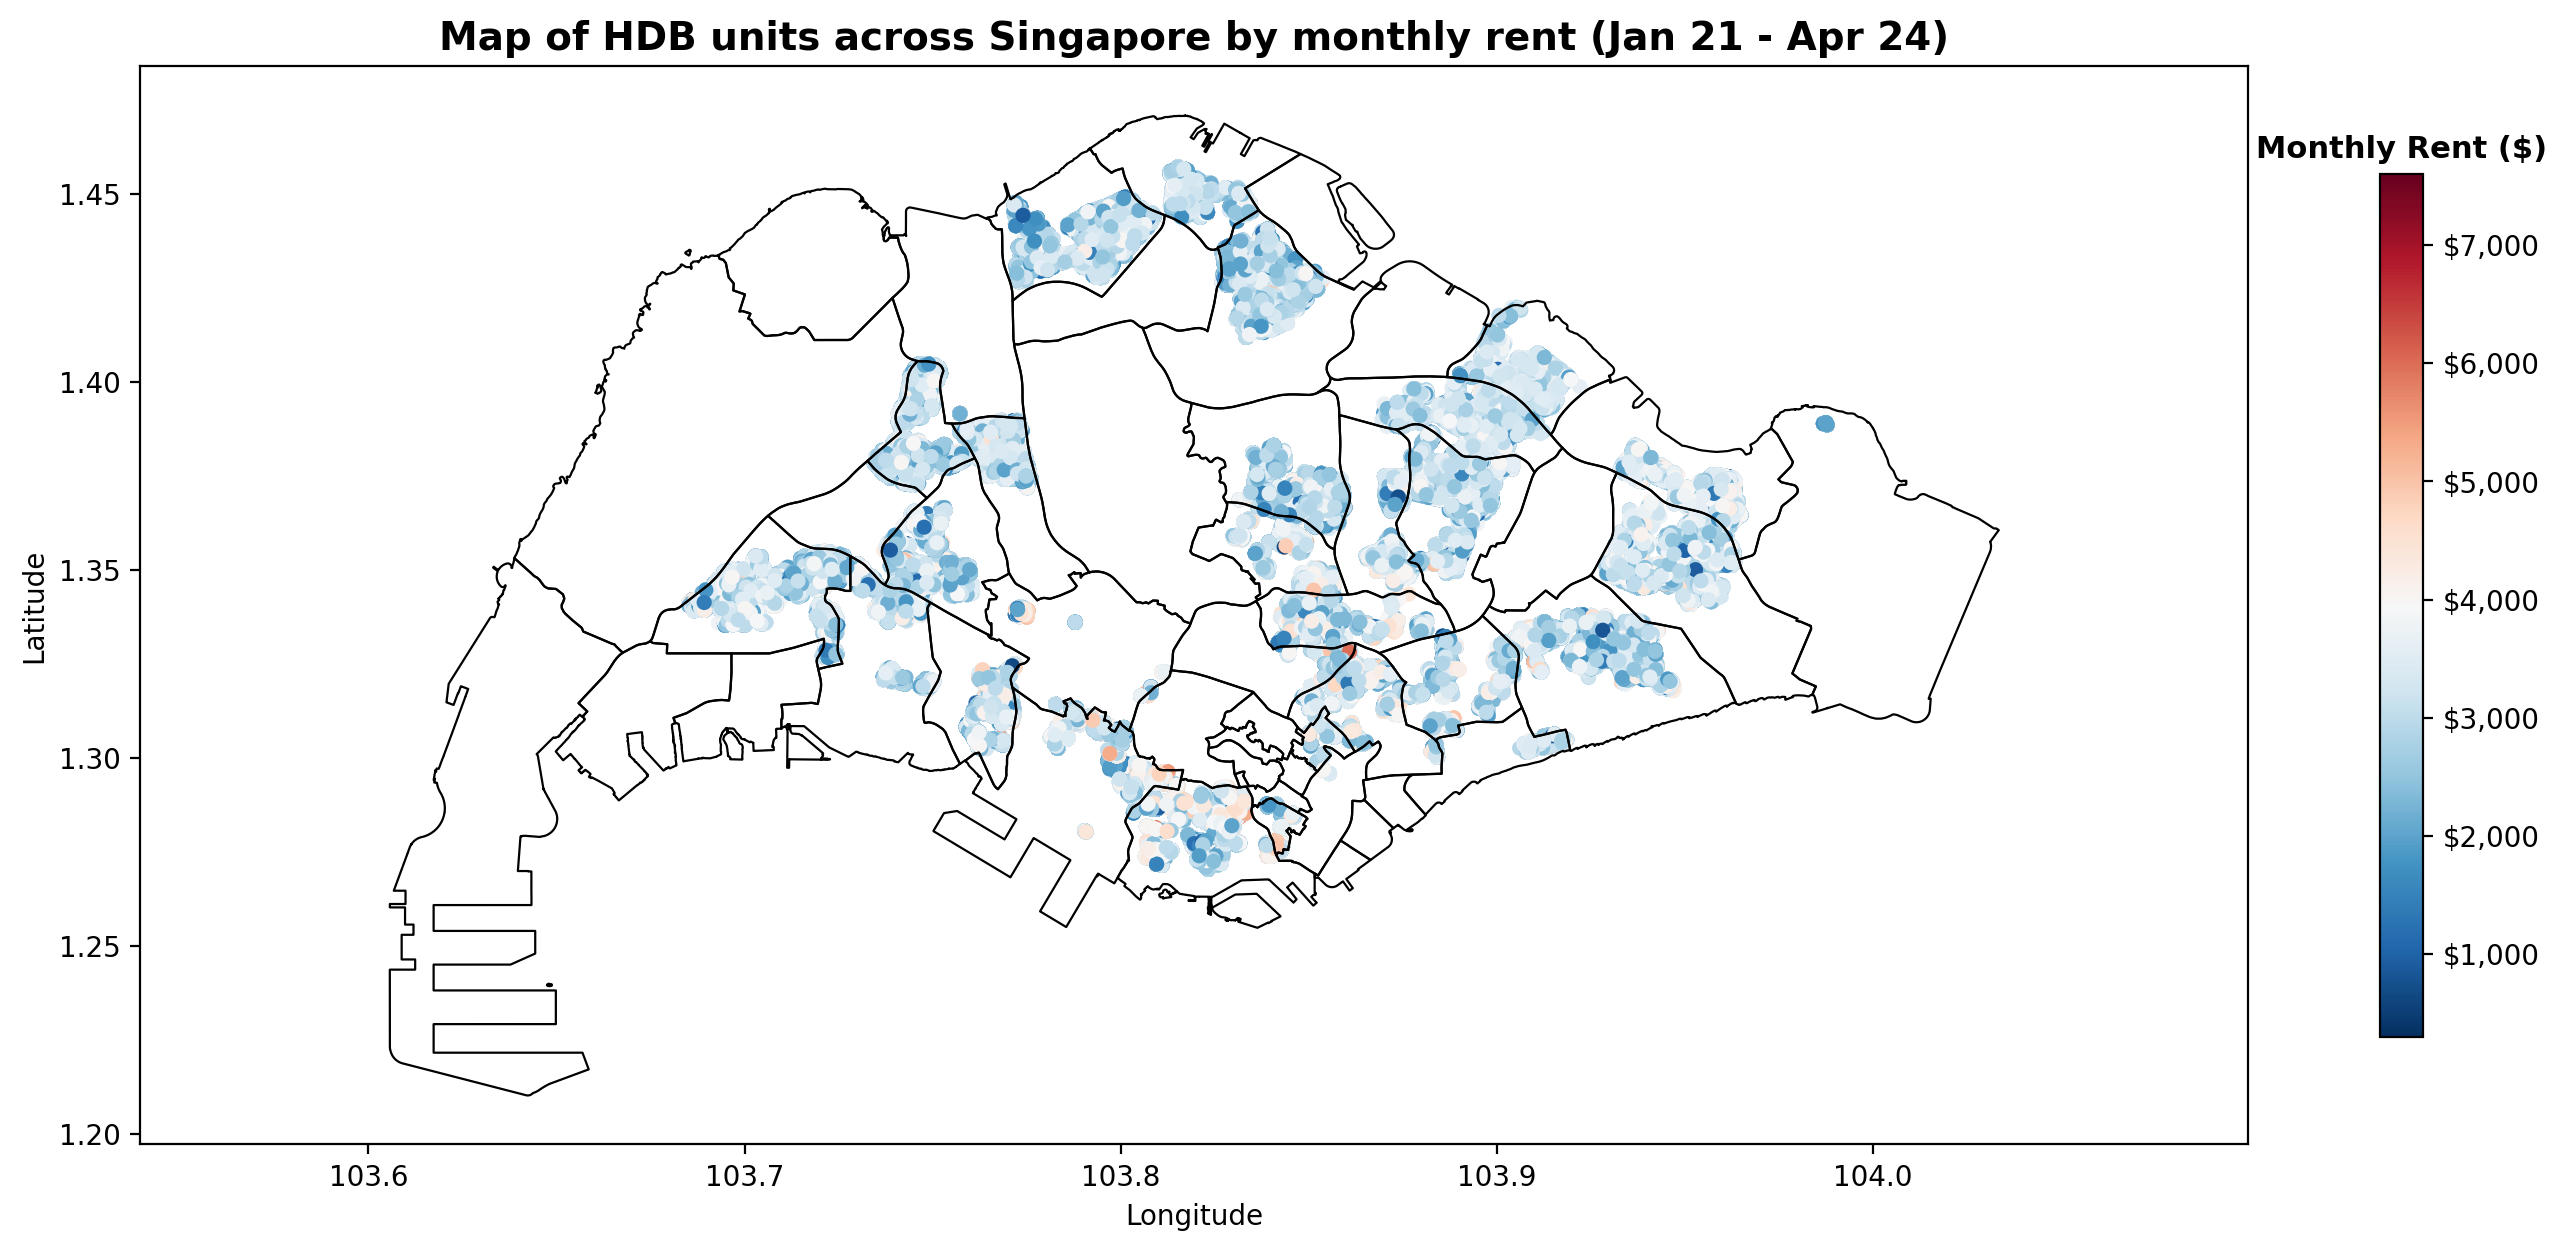

In [28]:
# Initiate figure
fig, ax = plt.subplots(figsize=(17,7))
plt.style.use('default')

# Scatterplot labels
plt.title('Map of HDB units across Singapore by monthly rent (Jan 21 - Apr 24)', fontweight='bold', fontsize=14)
plt.ylabel('Latitude')
plt.xlabel('Longitude')

# Plot basemap
sg_filtered.boundary.plot(edgecolor='black', ax=ax, linewidth=0.8)

# Plot location of HDB units with monthly rent as colour gradient
ax.scatter(x=longitude_2, y=latitude_2, c=rent['monthly_rent'], cmap='RdBu_r', s=20)

# Set equal axis for scaling
ax.axis('equal')

# Set equal axis for scaling
ax.axis('equal')

# Colour bar for to display monthly rent gradient, map colourmap and normalise range of values (min-max resale price) for colour mapping 
cmap = mpl.cm.RdBu_r
norm = mpl.colors.Normalize(vmin=np.min(rent['monthly_rent']), vmax=np.max(rent['monthly_rent']))

cbar = plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, location='right', shrink=0.8, pad=0.05)

# Format colour bar
cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f'${x:,.0f}'))
cbar.ax.set_title('Monthly Rent ($)', fontsize=11, fontweight='bold', horizontalalignment='center')

# Show scatterplot
plt.show()

Similar to the HDB resale price dataset, the rental dataset also allows for mapping of geocoordinates of each rental unit and colour-coding according to their monthly rent price, allowing for a granular spatial overview of rental options across Singapore. <br>

As observed with resale flats, higher-priced rentals tend to cluster in mature estates closer to the city, such as Bishan, Novena, and Bukit Merah. Conversely, more affordable rentals are typically found in heartlands and non-mature estates. <br>

However, it is worth noting that it is still possible to find reasonably priced rentals close to the city as well, such as certain locations within Bukit Merah and Chinatown.

# 3. Limitations of Study <a id = '3'></a> 

While the visualisations provide some guidance to prospective buyers for their housing purchases, it is worth noting that the prices in this study were aggregated over multiple years without accounting for inflation in this analysis. <br> 

To address this limitation, future work could involve calculating the net present value (NPV) based on historical prices. This approach would provide a more accurate comparison of numbers across different housing options, flat types, and estates in the present day by adjusting for inflation over time.